<a href="https://colab.research.google.com/github/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/main/TEMPLATE_Probabilistic_Machine_Learning_Project_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic Machine Learning - Project Report

**Course:** Probabilistic Machine Learning (SoSe 2025)

**Lecturer:** [Lecturer Name]  

**Student(s) Name(s):**  Samuel Rost

**GitHub Username(s):**  samueljar

**Date:**  11.06.2025

**PROJECT-ID:** [Assigned Project ID]  

---


## 1. Introduction

- Brief description of the dataset and problem
- Motivation for your project

<br><br>
Among the most scrutinized aspects of the game of Basketball is shooting performance—an inherently complex phenomenon influenced by a wide range of situational, spatial, and psychological factors. This project aims to explore and model player-specific shooting accuracy using comprehensive shot-level data from the 2014–2015 NBA season.

The dataset used in this project contains detailed information on nearly every shot attempted during the 2014–15 season. Each observed shot includes contextual game data (such as game ID, matchup, location, win/loss outcome, score margin), temporal indicators (game period, game clock, shot clock), as well as shot-specific attributes (dribbles before the shot, touch time, shot distance, shot result, points scored, field goals made). Crucially, the dataset also records the name and identity of the shooter, the identity and proximity of the closest defender, and the type of shot taken (e.g., 2PT or 3PT).


The following table provides brief explanations of each attribute in the dataset—each corresponding to a single shot attempt—to help readers, especially those less familiar with basketball, understand the contextual meaning of the variables used in the analysis.

<br>

| Attribute                    | Description                                                                                  |
|------------------------------|----------------------------------------------------------------------------------------------|
| `GAME_ID`                    | Unique identifier for the specific NBA game.                                                 |
| `MATCHUP`                    | The two teams playing in the game (e.g., "LAL vs BOS").                                      |
| `LOCATION`                   | Indicates if the shot was taken at home ("H") or away ("A").                                 |
| `WIN-LOSS`                   | Whether the shooter's team won or lost the game ("W" or "L").                                |
| `FINAL SCORE MARGIN`         | Point difference between the teams at the end of the game.                                   |
| `SHOT_NUMBER`                | The sequence number of the shot by the player in that game.                                  |
| `PERIOD`                     | Game period (1–4 for quarters, 5+ for overtime periods).                                     |
| `GAME_CLOCK`                 | Time left in the current period when the shot was taken (e.g., "02:35").                     |
| `SHOT_CLOCK`                 | Seconds remaining on the shot clock (24 seconds max) when the shot was taken.                |
| `DRIBBLES`                   | Number of dribbles taken by the player before attempting the shot.                           |
| `TOUCH_TIME`                 | How long (in seconds) the player held the ball before shooting.                              |
| `SHOT_DIST`                  | Distance from the basket (in feet) at which the shot was taken.                              |
| `PTS_TYPE`                   | Type of shot based on scoring value: 2 (2-point shot) or 3 (3-point shot).                   |
| `SHOT_RESULT`                | Whether the shot was made ("made") or missed ("missed").                                     |
| `CLOSEST_DEFENDER`           | Name of the defender closest to the shooter at the moment of the shot.                       |
| `CLOSEST_DEFENDER_PLAYER_ID` | Unique ID of the closest defender.                                                           |
| `CLOSE_DEF_DIST`             | Distance (in feet) between shooter and closest defender.                                     |
| `FGM` (Target Variable)                       | Field Goal Made: binary variable (1 if made, 0 if missed).                                   |
| `PTS`                        | Points scored by the shooter on that shot (0, 2, or 3).                                      |
| `player_name`                | Name of the player who took the shot.                                                        |
| `player_id`                  | Unique identifier of the player who took the shot.                                           |

<br><br>

#### Motivation

This rich and multidimensional dataset enables a detailed investigation into how various in-game factors affect shooting success on a player-by-player basis. The central motivation for this project is to model shooting percentages individually for each player and to understand how situational and environmental variables influence their shooting efficiency. For instance, do some players exhibit a significant decline in shooting accuracy under high-pressure scenarios, such as during clutch moments late in the game? How does shooting performance vary with increasing shot distance or as the proximity of the closest defender decreases? These questions touch not only on spatial and statistical relationships but also on potential psychological influences on player performance.

To capture these dynamics, I apply Bayesian logistic regression, modeling the probability of a shot being successful (i.e., a made field goal) as a function of relevant covariates. The binary nature of the response variable—made or missed shot—naturally lends itself to logistic regression. A Bayesian framework offers several advantages in this context: it allows for incorporating prior knowledge or regularization to account for limited data on specific players or situations; it produces full posterior distributions of the parameters, which is particularly valuable when dealing with uncertainty; and it enables hierarchical modeling, which can be extended to share information across players while still allowing individual-specific effects.

In summary, this project leverages advanced statistical modeling to examine NBA shooting data with the aim of uncovering deeper insights into individual player tendencies and the contextual factors that influence shooting success. The results can contribute to a more nuanced understanding of player efficiency and the psychological or tactical dimensions of shot-making in professional basketball.

<br><br>


## 2. Data Loading and Preprocessing


### 2.1 Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load data:
df = pd.read_csv('../data/shot_logs.csv')

### 2.2 Preprocessing

#### 2.2.1 Data Cleaning And Checking For Formatting-Inconsistencies, Missing Values etc.

In [5]:
def validate_data(df):
    """Perform comprehensive data validation on the basketball shots dataset"""
    
    # Initialize results dictionary
    validation_results = {
        'missing_values': {},
        'format_issues': {},
        'consistency_issues': []
    }
    
    # 1. Check for missing values in each column
    validation_results['missing_values'] = df.isnull().sum().to_dict()
    
    # 2. Check specific formatting issues
    format_issues = {}
    
    # Check GAME_CLOCK format (mm:ss)
    game_clock_ok = df['GAME_CLOCK'].str.match(r'^\d{1,2}:\d{2}$') | df['GAME_CLOCK'].isna()
    if not game_clock_ok.all():
        format_issues['GAME_CLOCK'] = f"{sum(~game_clock_ok)} rows with unexpected format"
    
    # Check SHOT_CLOCK values (between 0 and 24)
    shot_clock_issues = df['SHOT_CLOCK'].apply(lambda x: not (np.isnan(x) or (0 <= x <= 24)))
    if shot_clock_issues.any():
        format_issues['SHOT_CLOCK'] = f"{shot_clock_issues.sum()} rows with values outside 0-24 range"
    
    # Check LOCATION values (only A or H)
    location_issues = ~df['LOCATION'].isin(['A', 'H'])
    if location_issues.any():
        format_issues['LOCATION'] = f"{location_issues.sum()} rows with invalid location codes"
    
    # Check PERIOD values (1-4 for regulation, 5+ for OT)
    period_issues = df['PERIOD'] < 1
    if period_issues.any():
        format_issues['PERIOD'] = f"{period_issues.sum()} rows with invalid period numbers"
    
    validation_results['format_issues'] = format_issues
    
    # 3. Check data consistency
    consistency_issues = []
    
    # FGM should match SHOT_RESULT
    fgm_mismatch = (df['FGM'] == 1) != (df['SHOT_RESULT'] == 'made')
    if fgm_mismatch.any():
        consistency_issues.append(f"FGM/SHOT_RESULT mismatch in {fgm_mismatch.sum()} rows")
    
    # PTS should match PTS_TYPE when shot is made
    pts_mismatch = (df['FGM'] == 1) & (df['PTS'] != df['PTS_TYPE'])
    if pts_mismatch.any():
        consistency_issues.append(f"PTS/PTS_TYPE mismatch in {pts_mismatch.sum()} rows")
    
    # SHOT_DIST, CLOSEST_DEF_DIST, DRIBBLES, TOUCH_TIME should be positive
    shot_dist_issues = df['SHOT_DIST'] < 0
    if shot_dist_issues.any():
        consistency_issues.append(f"Negative SHOT_DIST in {shot_dist_issues.sum()} rows")
    def_dist_issues = df['CLOSE_DEF_DIST'] < 0
    if shot_dist_issues.any():
        consistency_issues.append(f"Negative CLOSEST_DEF_DIST in {def_dist_issues.sum()} rows")
    dribbles_issues = df['DRIBBLES'] < 0
    if shot_dist_issues.any():
        consistency_issues.append(f"Negative DRIBBLES in {dribbles_issues.sum()} rows")
    touch_time_issues = df['TOUCH_TIME'] < 0
    if shot_dist_issues.any():
        consistency_issues.append(f"Negative TOUCH_TIME in {touch_time_issues.sum()} rows")
    
    validation_results['consistency_issues'] = consistency_issues
    
    return validation_results

def generate_report(validation_results):
    """Generate a human-readable report from validation results"""
    report = []
    
    # Missing values section
    report.append("=== MISSING VALUES ===")
    missing_values = validation_results['missing_values']
    if any(missing_values.values()):
        for col, count in missing_values.items():
            if count > 0:
                report.append(f"{col}: {count} missing values")
    else:
        report.append("No missing values found in any column")
    
    # Format issues section
    report.append("\n=== FORMAT ISSUES ===")
    format_issues = validation_results['format_issues']
    if format_issues:
        for col, issue in format_issues.items():
            report.append(f"{col}: {issue}")
    else:
        report.append("No formatting issues found")
    
    # Consistency issues section
    report.append("\n=== CONSISTENCY ISSUES ===")
    consistency_issues = validation_results['consistency_issues']
    if consistency_issues:
        for issue in consistency_issues:
            report.append(issue)
    else:
        report.append("No consistency issues found")
    
    return "\n".join(report)

def identify_problematic_rows(df, validation_results):
    """Identify rows with any issues"""
    mask = pd.Series(False, index=df.index)
    
    # Missing values
    for col, count in validation_results['missing_values'].items():
        if count > 0:
            mask |= df[col].isna()
    
    if 'GAME_CLOCK' in validation_results['format_issues']:
        mask |= ~df['GAME_CLOCK'].str.match(r'^\d{1,2}:\d{2}$')
    
    # Consistency issues
    mask |= (df['FGM'] == 1) != (df['SHOT_RESULT'] == 'made')
    mask |= (df['FGM'] == 1) & (df['PTS'] != df['PTS_TYPE'])
    mask |= (df['SHOT_DIST'] < 0)
    
    return df[mask]



if __name__ == '__main__':
    # Load the dataset
    try:
        df = pd.read_csv('../data/shot_logs.csv')
    except FileNotFoundError:
        print("Error: File not found. Please check the filename and path.")
    
    # Perform validation
    validation_results = validate_data(df)
    
    # Generate and print report
    report = generate_report(validation_results)
    print(report)
    
    # Save problematic rows to a file for inspection
    if any(validation_results['missing_values'].values()) or validation_results['format_issues'] or validation_results['consistency_issues']:
        problematic_rows = identify_problematic_rows(df, validation_results)
        problematic_rows.to_csv('problematic_rows.csv', index=False)
        print("\nProblematic rows saved to 'problematic_rows.csv'")

=== MISSING VALUES ===
SHOT_CLOCK: 5567 missing values

=== FORMAT ISSUES ===
No formatting issues found

=== CONSISTENCY ISSUES ===
No consistency issues found

Problematic rows saved to 'problematic_rows.csv'


#### 2.2.2 Data Transformation/ Feature-Engineering (creating new features for data analysis)

In [6]:
# creating CLUTCH_TIME attribute
game_clock = pd.to_timedelta('00:' + df['GAME_CLOCK'].astype(str))          # Converting game clock to timedelta
df['CLUTCH_TIME'] = ((df['PERIOD'] >= 4) &                                  # shots in fourth quater or overtime
                     (abs(df['FINAL_MARGIN']) < 10) &                       # game is close (finale pts-margin within 10 pts)
                     (game_clock <= pd.Timedelta(minutes=4))).astype(int)   # within last 4 minutes of last quater

# creating shooting zones based on SHOT_DISTANCE
df['SHOT_ZONE'] = pd.cut(
                         df['SHOT_DIST'], 
                         bins=[0, 4, 14, 24, 35],
                         labels=['Restricted Area', 'Paint', 'Mid-Range', '3PT']
                        )
# Create binary columns for each zone (one-hot encoding)
df['RESTRICTED_AREA'] = (df['SHOT_ZONE'] == 'Restricted Area').astype(int)
df['PAINT']            = (df['SHOT_ZONE'] == 'Paint').astype(int)
df['MID_RANGE']        = (df['SHOT_ZONE'] == 'Mid-Range').astype(int)
df['3PT']              = (df['SHOT_ZONE'] == '3PT').astype(int)

In [7]:
# Creating additional features that might be relevant:
# Inverse defender-distance metric
df['DEFENDER_PROXIMITY'] = 1 / (df['CLOSE_DEF_DIST'] + 0.1)

# Create time pressure feature boolean feature set to true if shot taken with less than 3 seconds left on shot-clock
df['TIME_PRESSURE'] = (df['SHOT_CLOCK'] < 3).astype(int)

# Create fatigue indicator based on period
df['LATE_GAME'] = (df['PERIOD'] > 4).astype(int)

# Create home/away indicator
df['HOME_GAME'] = (df['LOCATION'] == 'H').astype(int)

In [8]:
# storing modified dataframe to new csv-file
df.to_csv('../data/shot_logs_modified.csv', index=False)

## 3. Data Exploration

#### 3.1 Plotting Players With Most Shots Taken In 2014/15 NBA Season

In [8]:
# load data:
shot_logs = pd.read_csv('../data/shot_logs_modified.csv')


Top 30 Spieler nach Schussversuchen:
-----------------------------------
1. james harden
2. mnta ellis
3. lamarcus aldridge
4. damian lillard
5. lebron james
6. klay thompson
7. russell westbrook
8. stephen curry
9. kyrie irving
10. tyreke evans
11. nikola vucevic
12. blake griffin
13. chris paul
14. rudy gay
15. kyle lowry
16. john wall
17. gordon hayward
18. anthony davis
19. markieff morris
20. brandon knight
21. pau gasol
22. dirk nowtizski
23. marc gasol
24. jamal crawford
25. al jefferson
26. andrew wiggins
27. carmelo anthony
28. demarcus cousins
29. trey burke
30. jimmy butler


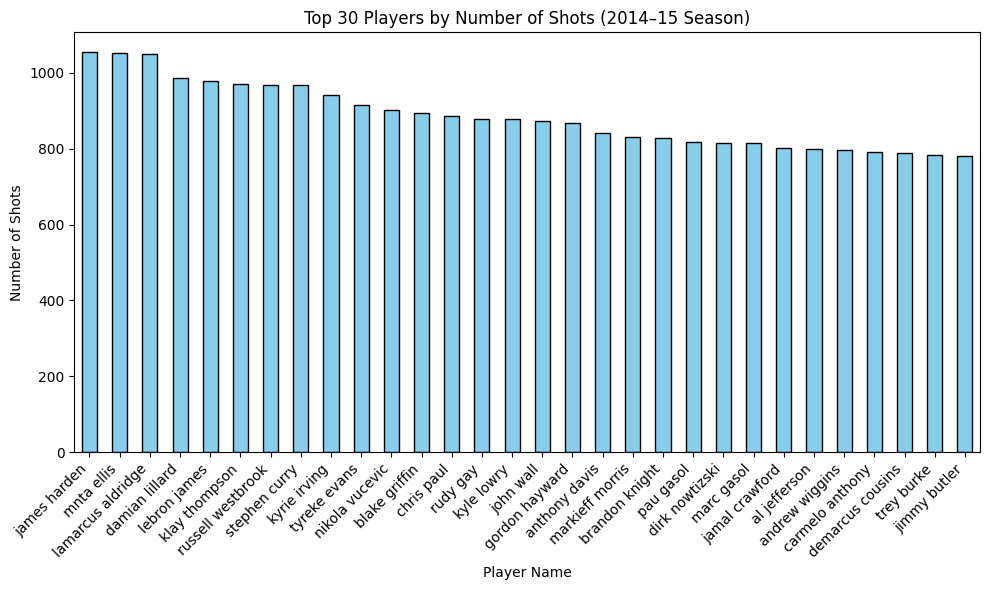

In [10]:
# Top 30 Spieler nach Schussversuchen
top_n=30
top_30_players = df['player_name'].value_counts().head(top_n)

# Ausgabe
print("\nTop 30 Spieler nach Schussversuchen:")
print("-----------------------------------")
for i, player in enumerate(top_30_players.index.tolist(), 1):
    print(f"{i}. {player}")


# Barplot
plt.figure(figsize=(10, 6))
top_30_players.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Player Name')
plt.ylabel('Number of Shots')
plt.title(f'Top {top_n} Players by Number of Shots (2014–15 Season)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### 3.2 Plotting The Distribution Of Players By Total Number Of Shot-Attempts

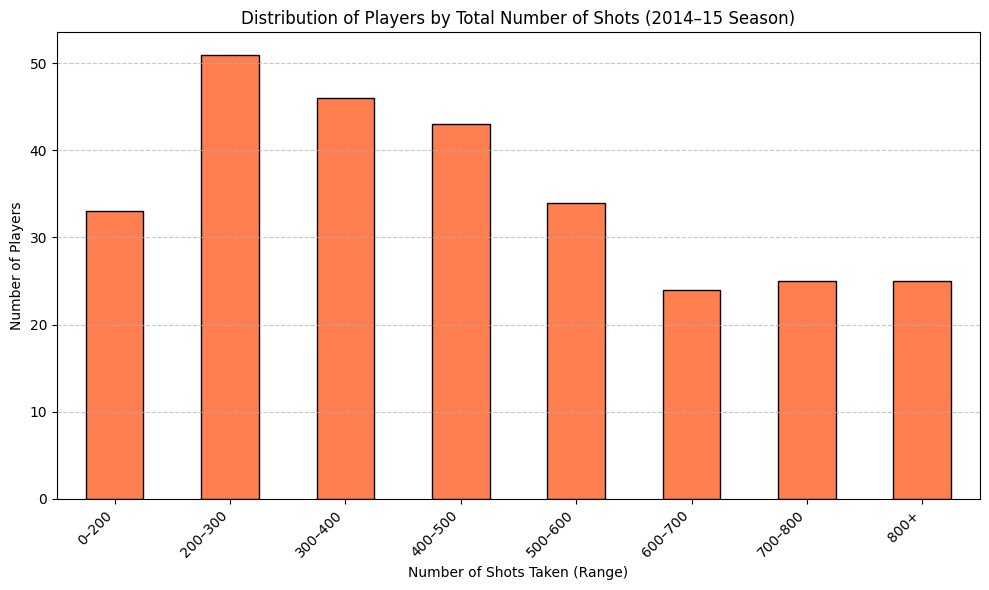

In [11]:
# Number of shots per player 
shot_counts = shot_logs['player_name'].value_counts()

# Defining ranges (Bins)
bins = [0, 200, 300, 400, 500, 600, 700, 800, 2000]
labels = [f'{bins[i]}–{bins[i+1]}' for i in range(len(bins)-2)]
labels.append('800+')

#  Sorting players to their respective range of attempted shots 
shot_bins = pd.cut(shot_counts, bins=bins, labels=labels, right=False)

# Counting players per range
range_counts = shot_bins.value_counts().sort_index()

# Barplot
plt.figure(figsize=(10, 6))
range_counts.plot(kind='bar', color='coral', edgecolor='black')

plt.xlabel('Number of Shots Taken (Range)')
plt.ylabel('Number of Players')
plt.title('Distribution of Players by Total Number of Shots (2014–15 Season)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### 3.3 Shooting-Efficiency Based On Distance (Shot-Zone) To The Basket


Overall FG%: 45.21%


Shooting percentage by zone:
                    FG%  Count
SHOT_ZONE                     
Restricted Area  63.58%  26701
Paint            45.13%  38115
Mid-Range        39.65%  41047
3PT              33.89%  21953



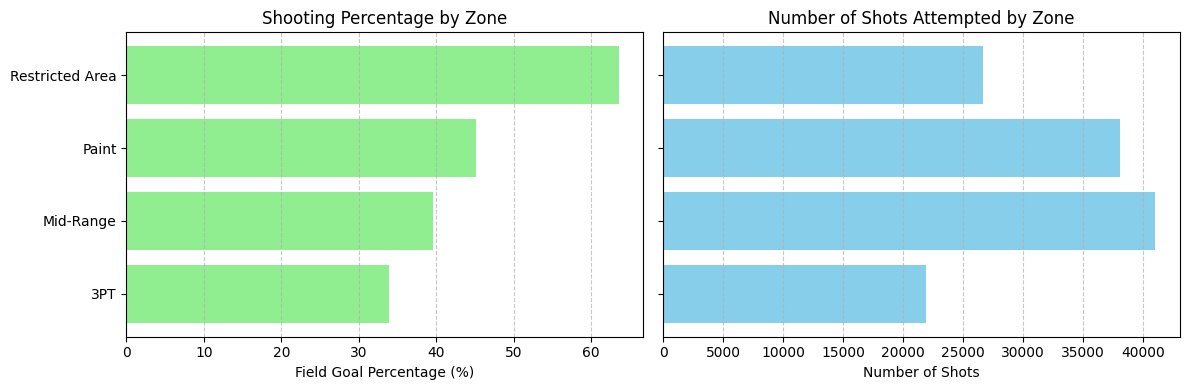

In [12]:
# Overall shooting percentage
print(f"\nOverall FG%: {df['FGM'].mean():.2%}\n")


# Number of shots taken by shooting-zones & Shooting percentage by zone
zone_stats = df.groupby('SHOT_ZONE')['FGM'].agg(['mean', 'count'])
zone_stats.columns = ['FG%', 'Count']
zone_stats['FG%'] = zone_stats['FG%'].apply(lambda x: f"{x:.2%}")
print("\nShooting percentage by zone:")
print(f"{zone_stats}\n")


# Plot-data
zone_stats = df.groupby('SHOT_ZONE')['FGM'].agg(['mean', 'count'])
zone_stats.columns = ['FG%', 'Shot Count']
zone_stats['FG%'] = zone_stats['FG%'] * 100  # Convert to percentage
# Sort by FG% instead of Shot Count (this is the key change)
zone_stats = zone_stats.sort_values('FG%')

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot 1 (left): Shot Count
ax2.barh(zone_stats.index, zone_stats['Shot Count'], color='skyblue')
ax2.set_title('Number of Shots Attempted by Zone')
ax2.set_xlabel('Number of Shots')
ax2.grid(axis='x', linestyle='--', alpha=0.7)

# Plot 2 (right): Shooting Percentage
ax1.barh(zone_stats.index, zone_stats['FG%'], color='lightgreen')
ax1.set_title('Shooting Percentage by Zone')
ax1.set_xlabel('Field Goal Percentage (%)')
ax1.grid(axis='x', linestyle='--', alpha=0.7)

#plt.suptitle('Shot Distribution and Efficiency by Zone', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

#### 3.4. Disentangling the Effects of Closest Defender Distance and Shot Distance on Field Goal Percentage:

While greater defender distance generally correlates with improved shooting efficiency, longer shots tend to have lower success rates. Because these two factors often move in opposite directions, examining closest defender distance alone can obscure their true impact. To address this, I stratify FG% by both defender proximity and shot type (2PT vs 3PT), revealing their combined influence on shooting outcomes.


Percentage of 2PT vs 3PT shots by defender distance:
PTS_TYPE                 2      3
CLOSE_DEF_DIST_BINS              
0-2ft                97.3%   2.7%
2-4ft                85.9%  14.1%
4-6ft                59.2%  40.8%
6-10ft               43.5%  56.5%
10+ft                32.0%  68.0%

Shooting percentage and number of attempts by defender distance and shot type:
                                FG%   Shots
CLOSE_DEF_DIST_BINS PTS_TYPE               
0-2ft               2         45.9%  24,234
                    3         22.9%     672
2-4ft               2         49.6%  39,682
                    3         31.2%   6,500
4-6ft               2         49.0%  20,222
                    3         34.6%  13,944
6-10ft              2         52.1%   7,585
                    3         37.9%   9,848
10+ft               2         59.5%   1,327
                    3         40.6%   2,825

League average shooting percentages:
PTS_TYPE
2    48.8%
3    35.2%
Name: FGM, dtype: object


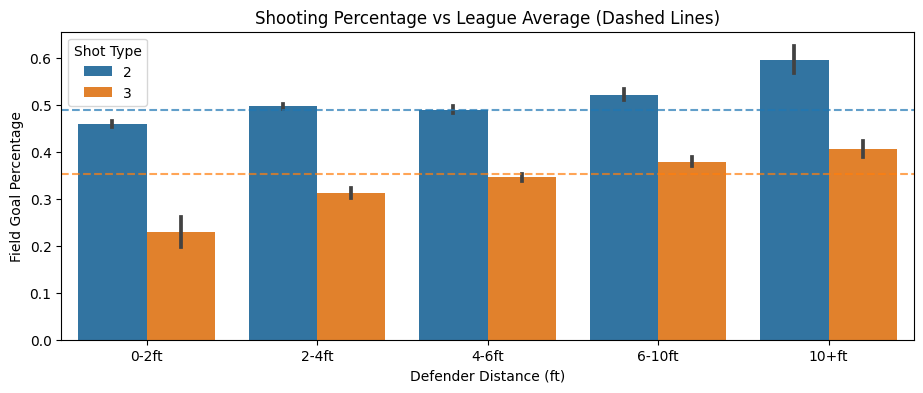

In [14]:
# Binning of Clostest-Defender.Distance
defender_bins = [0, 2, 4, 6, 10, 20]
defender_labels = ['0-2ft', '2-4ft', '4-6ft', '6-10ft', '10+ft']
df['CLOSE_DEF_DIST_BINS'] = pd.cut(
    df['CLOSE_DEF_DIST'],
    bins=defender_bins,
    labels=defender_labels
)

# 1. overall distribution of shot types by defender distance
shot_type_dist = pd.crosstab(
    df['CLOSE_DEF_DIST_BINS'],
    df['PTS_TYPE'],
    normalize='index'
)
print("\nPercentage of 2PT vs 3PT shots by defender distance:")
print(shot_type_dist.applymap(lambda x: f"{x:.1%}"))

# 2. overall FG% by defender distance and shot type
defender_shot_stats = df.groupby(['CLOSE_DEF_DIST_BINS', 'PTS_TYPE'])['FGM'].agg(
    ['mean', 'count']
).rename(columns={'mean': 'FG%', 'count': 'Shots'})
# Format output
defender_shot_stats['FG%'] = defender_shot_stats['FG%'].apply(lambda x: f"{x:.1%}")
defender_shot_stats['Shots'] = defender_shot_stats['Shots'].apply(lambda x: f"{x:,}")

print("\nShooting percentage and number of attempts by defender distance and shot type:")
print(defender_shot_stats)



# 3. Visualization - Comparison to league average by shot type
# Calculate league averages for each shot type
league_avg = df.groupby('PTS_TYPE')['FGM'].mean()
print("\nLeague average shooting percentages:")
print(league_avg.apply(lambda x: f"{x:.1%}"))

# Plot comparison to league average
plt.figure(figsize=(11, 4))
ax = sns.barplot(
    x='CLOSE_DEF_DIST_BINS',
    y='FGM',
    hue='PTS_TYPE',
    data=df,
    order=defender_labels,
    errorbar=('ci', 95)
)

# Add horizontal lines for league averages
for i, shot_type in enumerate(league_avg.index):
    ax.axhline(league_avg[shot_type], 
               color=sns.color_palette()[i], 
               linestyle='--',
               alpha=0.7)
plt.title('Shooting Percentage vs League Average (Dashed Lines)')
plt.xlabel('Defender Distance (ft)')
plt.ylabel('Field Goal Percentage')
plt.legend(title='Shot Type')
plt.show()

#### 3.5 Correlations Between Features:

In [48]:
features_of_interest = [
    'FGM',

    'SHOT_DIST',
    'RESTRICTED_AREA',
    'PAINT',
    'MID_RANGE',
    '3PT',
    
    'SHOT_CLOCK',
    'HOME_GAME',
    
    'CLOSE_DEF_DIST',
    'DEFENDER_PROXIMITY',

    'SHOT_NUMBER',
    'LATE_GAME',
    'PERIOD',
    'CLUTCH_TIME',
    'TIME_PRESSURE',
    
    'DRIBBLES',
    'TOUCH_TIME',
]

##### Correlations of Shooting-Features with target-variable FGM ("Field Goal Made"):


Sorted Correlations By Absolute Values:
FGM                   1.000000
SHOT_DIST            -0.191704
RESTRICTED_AREA       0.189410
3PT                  -0.103522
SHOT_CLOCK            0.096855
MID_RANGE            -0.076782
TIME_PRESSURE        -0.051010
TOUCH_TIME           -0.045299
DRIBBLES             -0.034390
CLUTCH_TIME          -0.015010
PERIOD               -0.014082
LATE_GAME            -0.010560
SHOT_NUMBER          -0.008351
HOME_GAME             0.008093
DEFENDER_PROXIMITY   -0.001220
PAINT                -0.001142
CLOSE_DEF_DIST       -0.001074
Name: FGM, dtype: float64





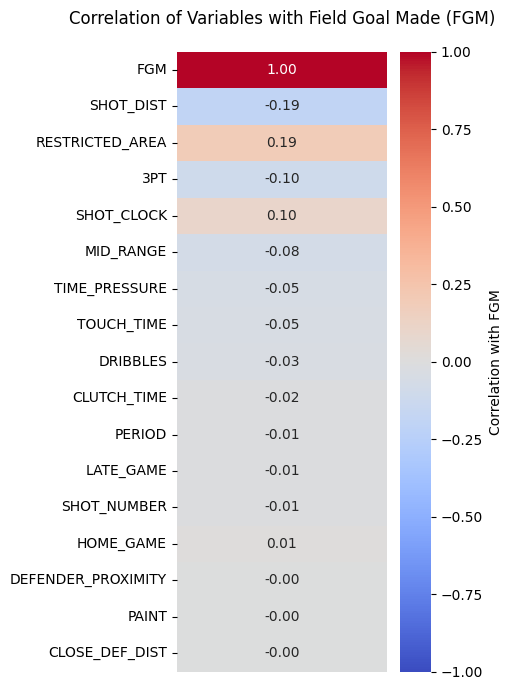

In [62]:
correlation = df[features_of_interest].corr()['FGM']
correlation_sorted = correlation.reindex(correlation.abs().sort_values(ascending=False).index)

print(f"\nSorted Correlations By Absolute Values:\n{correlation_sorted}\n\n\n")

# Create heatmap
plt.figure(figsize=(5, 7))
sns.heatmap(correlation_sorted.to_frame("Test"), 
            annot=True, 
            fmt=".2f",
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            cbar_kws={'label': 'Correlation with FGM'})

plt.title('Correlation of Variables with Field Goal Made (FGM)', pad=20)
plt.yticks(rotation=0)
plt.xticks([])  # Remove x-axis label since we only have FGM
plt.tight_layout()
plt.show()

##### Correlations of Shooting-Features with variable closest-defender-distance:


Sorted Correlations By Absolute Values (CLOSE_DEF_DIST):
CLOSE_DEF_DIST     1.000000
SHOT_DIST          0.523192
PAINT             -0.317126
MID_RANGE          0.304775
3PT                0.297722
RESTRICTED_AREA   -0.272868
TOUCH_TIME        -0.164737
DRIBBLES          -0.153674
SHOT_NUMBER       -0.037769
SHOT_CLOCK         0.026558
TIME_PRESSURE     -0.015200
CLUTCH_TIME       -0.012818
PERIOD            -0.010204
LATE_GAME         -0.008457
HOME_GAME          0.003579
FGM               -0.001074
Name: CLOSE_DEF_DIST, dtype: float64





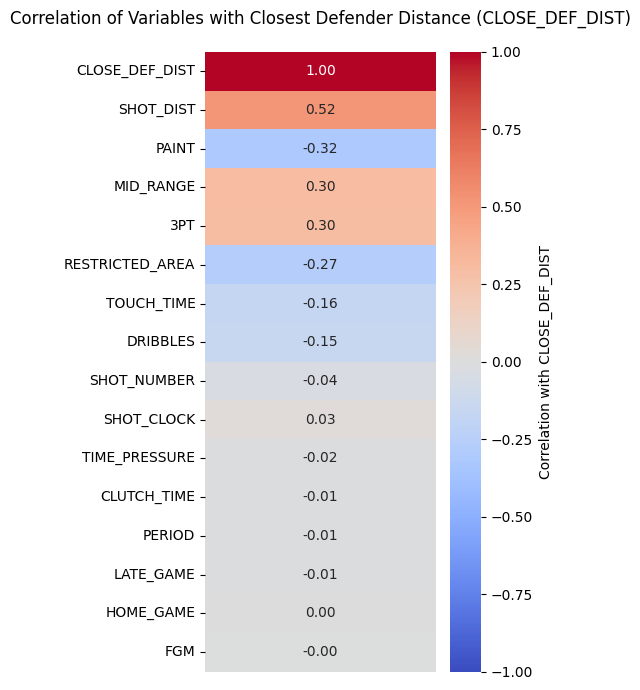

In [61]:
# Calculate correlations of CLOSE_DEF_DIST with other shooting-specific features (but excluding 'DEFENDER_PROXIMITY')
correlation = df[[f for f in features_of_interest if f != 'DEFENDER_PROXIMITY']].corr()['CLOSE_DEF_DIST']
# Sort by absolute value, keep sign
correlation_sorted = correlation.reindex(correlation.abs().sort_values(ascending=False).index)
print(f"\nSorted Correlations By Absolute Values (CLOSE_DEF_DIST):\n{correlation_sorted}\n\n\n")

# Create heatmap
plt.figure(figsize=(5, 7))
sns.heatmap(
    correlation_sorted.to_frame("Test"), 
    annot=True, 
    fmt=".2f",
    cmap='coolwarm', 
    center=0,
    vmin=-1, 
    vmax=1,
    cbar_kws={'label': 'Correlation with CLOSE_DEF_DIST'}
)
plt.title('Correlation of Variables with Closest Defender Distance (CLOSE_DEF_DIST)', pad=20)
plt.yticks(rotation=0)
plt.xticks([])  # Remove x-axis label since we only have one target variable
plt.tight_layout()
plt.show()

##### Full correlation-matrix:

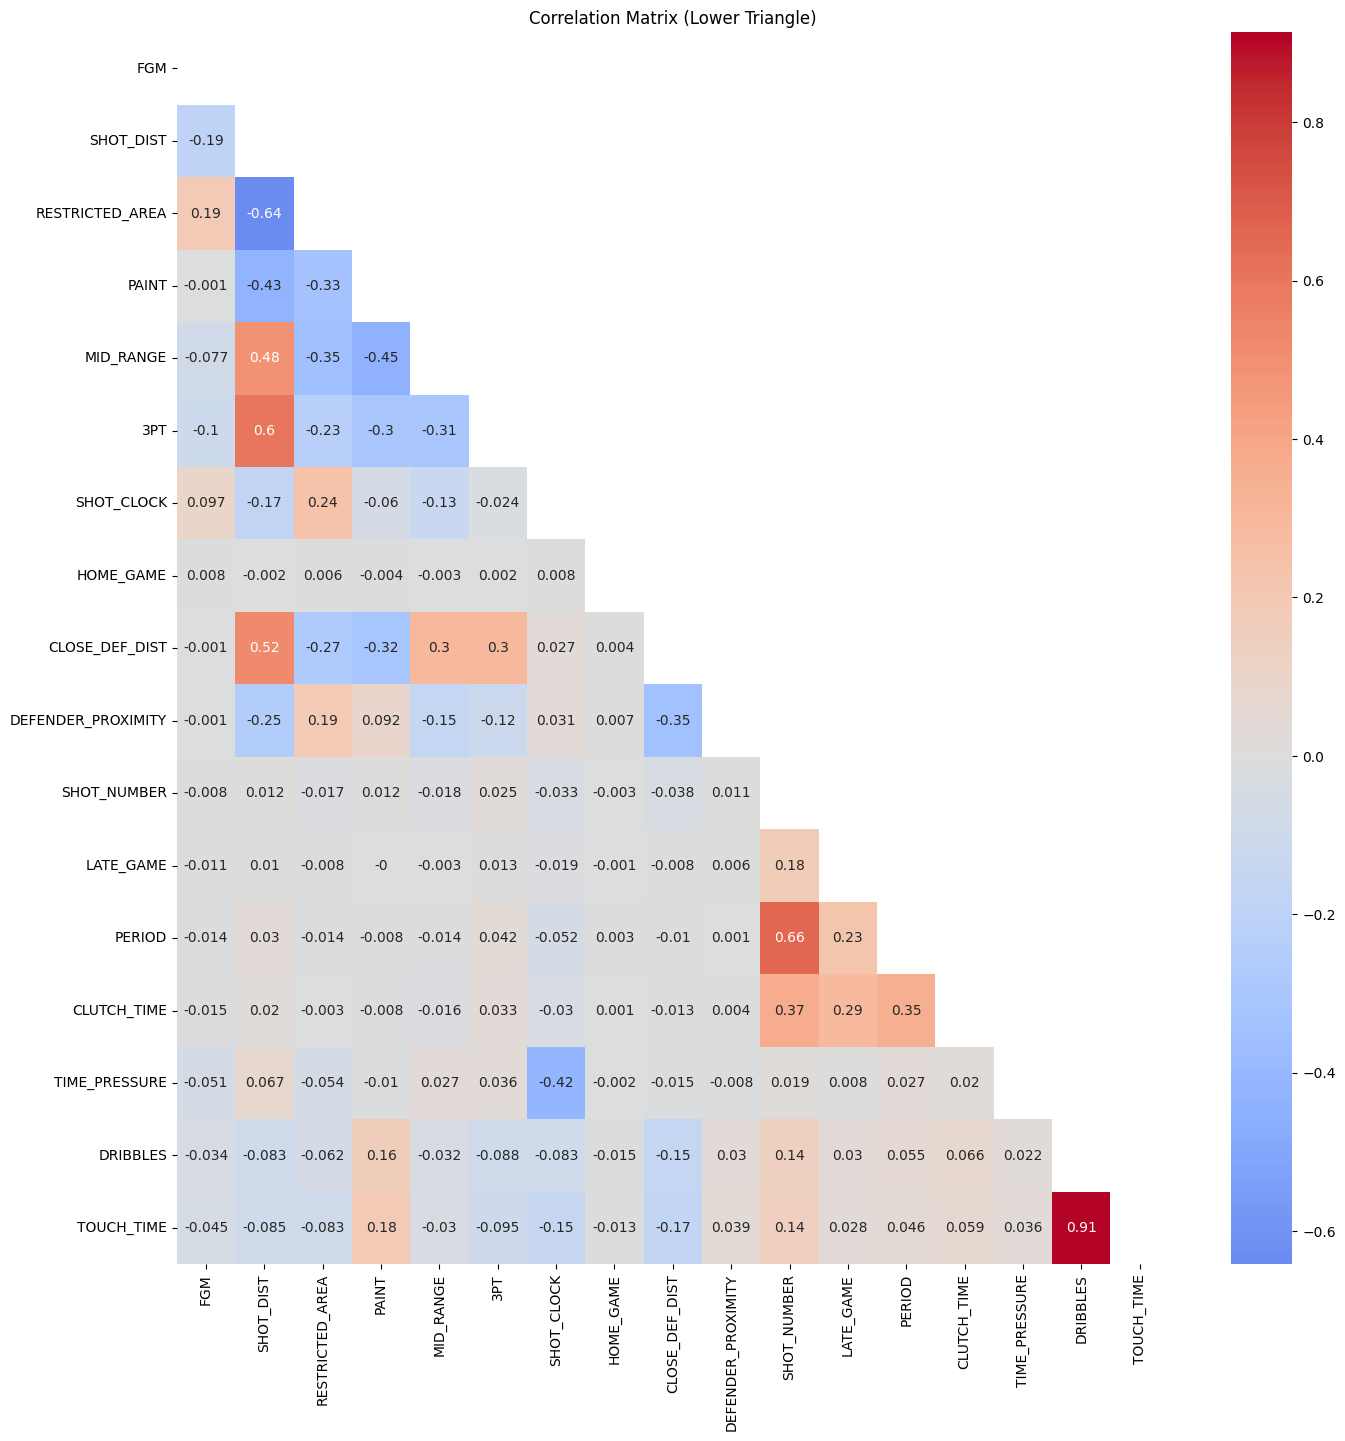

In [40]:
# Compute full correlation matrix
correlation_matrix = df[features_of_interest].corr()
# Round correlation values to three decimal places
correlation_matrix = correlation_matrix.round(3)
# Create mask for the upper triangle (to hide redundant half)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot heatmap (only lower half shown)
plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Lower Triangle)')
plt.show()

#### 3.6 Clutch-Time Shooting Analysis

##### Basic Clutch-Shooting Stats:

In [16]:
# Clutch-Time Shooting Analysis
clutch_df = df[df['CLUTCH_TIME'] == 1]

# 1. Basic Clutch Stats
total_clutch_shots = len(clutch_df)
clutch_fg_percentage = clutch_df['FGM'].mean()
total_shots = len(df)
clutch_shot_ratio = total_clutch_shots / total_shots

print(f"\nClutch-Time Shooting Analysis (Last 4 mins, close game ±10 pts)")
print(f"-------------------------------------------------------")
print(f"Total clutch shots: {total_clutch_shots:,} ({clutch_shot_ratio:.1%} of all shots)")
print(f"Clutch FG%: {clutch_fg_percentage:.1%}")
print(f"League average FG%: {df['FGM'].mean():.1%}")

# 2. Comparison to Non-Clutch
non_clutch_df = df[df['CLUTCH_TIME'] == 0]
non_clutch_fg = non_clutch_df['FGM'].mean()

print(f"\nPerformance Comparison:")
print(f"Non-Clutch FG%: {non_clutch_fg:.1%}")
print(f"Difference:     {clutch_fg_percentage-non_clutch_fg:+.1%}")


# 3. Shooting percentages of shots taken in clutch-time
# Clutch time shooting stats by zone
clutch_zone_stats = df[df['CLUTCH_TIME'] == 1].groupby('SHOT_ZONE')['FGM'].agg(['mean', 'count'])
clutch_zone_stats.columns = ['Clutch FG%', 'Clutch Shot-Count']
# Non-clutch time shooting stats by zone
non_clutch_zone_stats = df[df['CLUTCH_TIME'] == 0].groupby('SHOT_ZONE')['FGM'].agg(['mean', 'count'])
non_clutch_zone_stats.columns = ['Non-Clutch FG%', 'Non-Clutch Shot-Count']
# Combine both into a single dataframe
zone_comparison = pd.concat([clutch_zone_stats, non_clutch_zone_stats], axis=1)
# Format FG% as percentages
zone_comparison['Clutch FG%'] = zone_comparison['Clutch FG%'].apply(lambda x: f"{x:.2%}")
zone_comparison['Non-Clutch FG%'] = zone_comparison['Non-Clutch FG%'].apply(lambda x: f"{x:.2%}")
print("\n\nComparison of shooting percentages by zone during Clutch and Non-Clutch time:\n")
print(zone_comparison)



Clutch-Time Shooting Analysis (Last 4 mins, close game ±10 pts)
-------------------------------------------------------
Total clutch shots: 7,008 (5.5% of all shots)
Clutch FG%: 42.1%
League average FG%: 45.2%

Performance Comparison:
Non-Clutch FG%: 45.4%
Difference:     -3.3%


Comparison of shooting percentages by zone during Clutch and Non-Clutch time:

                Clutch FG%  Clutch Shot-Count Non-Clutch FG%  \
SHOT_ZONE                                                      
Restricted Area     64.42%               1422         63.53%   
Paint               42.13%               1977         45.29%   
Mid-Range           36.64%               2028         39.81%   
3PT                 29.27%               1568         34.24%   

                 Non-Clutch Shot-Count  
SHOT_ZONE                               
Restricted Area                  25279  
Paint                            36138  
Mid-Range                        39019  
3PT                              20385  


##### Player-Specific Clutch Shooting-Stats:

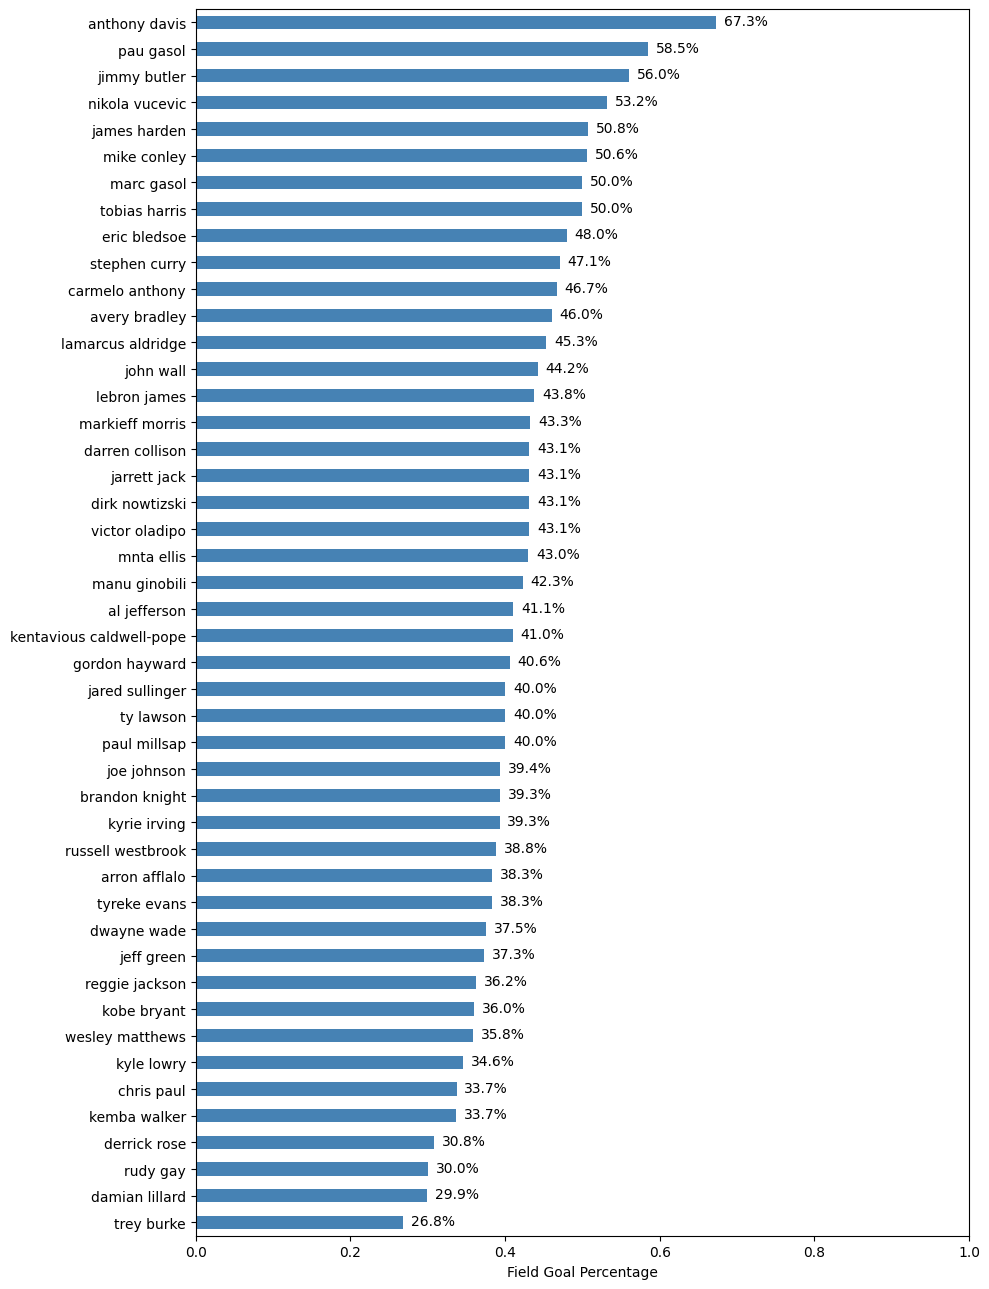

In [23]:
# 3. Clutch Performance by Player (min 50 clutch attempts)
player_clutch = clutch_df.groupby('player_name')['FGM'].agg(['mean', 'count'])
player_clutch = player_clutch[player_clutch['count'] >= 50].sort_values('mean', ascending=False)

# 3.1 Visualization:
plt.figure(figsize=(10, 13))
# Sortierte Clutch-Shooter als horizontale Balken
top_players = player_clutch['mean']
# Sortieren für bessere Darstellung
top_players = top_players.sort_values(ascending=True)
# Plot erstellen
ax = top_players.plot(kind='barh', color='steelblue')

# Beschriftungen hinzufügen
#plt.title('Sorted Clutch-Shooter (min. 50 attempts)', pad=20)
plt.xlabel('Field Goal Percentage')
plt.ylabel('')
plt.xlim(0, 1.0)  # 0-70% Skalierung

# Prozentwerte an die Balken schreiben
for i, v in enumerate(top_players):
    ax.text(v + 0.01, i - 0.1, f"{v:.1%}", color='black')

plt.tight_layout()
plt.show()

#### 3.7 More In-Depth Feature Analysis and Diagnostics

Variance Inflation Factors:
          Feature       VIF
3      TOUCH_TIME  7.431474
2        DRIBBLES  7.382731
4        PTS_TYPE  2.130697
6       HOME_GAME  1.962516
8     CLUTCH_TIME  1.360619
0       SHOT_DIST  1.318919
1  CLOSE_DEF_DIST  1.310240
5     SHOT_NUMBER  1.228865
7       LATE_GAME  1.104107
9   TIME_PRESSURE  1.063385



          Feature  MI_Score
0       SHOT_DIST  0.015192
4        PTS_TYPE  0.008943
7       LATE_GAME  0.003582
5     SHOT_NUMBER  0.003449
2        DRIBBLES  0.002454
1  CLOSE_DEF_DIST  0.002342
3      TOUCH_TIME  0.002070
6       HOME_GAME  0.001803
8     CLUTCH_TIME  0.000411
9   TIME_PRESSURE  0.000000


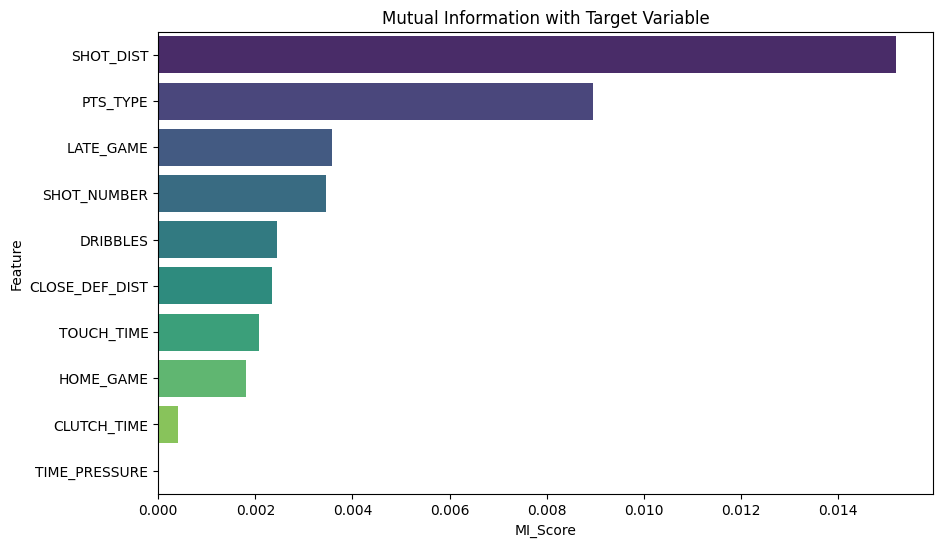


Statistical Significance Tests:
          Feature    Mean_1    Mean_0  T-statistic        P-value
0       SHOT_DIST -0.193329  0.164258   -26.369275  9.715782e-151
4        PTS_TYPE  2.172269  2.262255   -16.042917   1.397038e-57
3      TOUCH_TIME -0.058484  0.049690    -7.912983   2.636308e-15
9   TIME_PRESSURE  0.036380  0.055725    -6.765702   1.361227e-11
2        DRIBBLES -0.043157  0.036668    -5.832528   5.539347e-09
1  CLOSE_DEF_DIST  0.019369 -0.016457     2.570338   1.016733e-02
6       HOME_GAME  0.506559  0.492033     2.110221   3.485131e-02
8     CLUTCH_TIME  0.070199  0.076448    -1.744012   8.117176e-02
5     SHOT_NUMBER -0.011249  0.009558    -1.512917   1.303159e-01
7       LATE_GAME  0.009633  0.010361    -0.532429   5.944345e-01


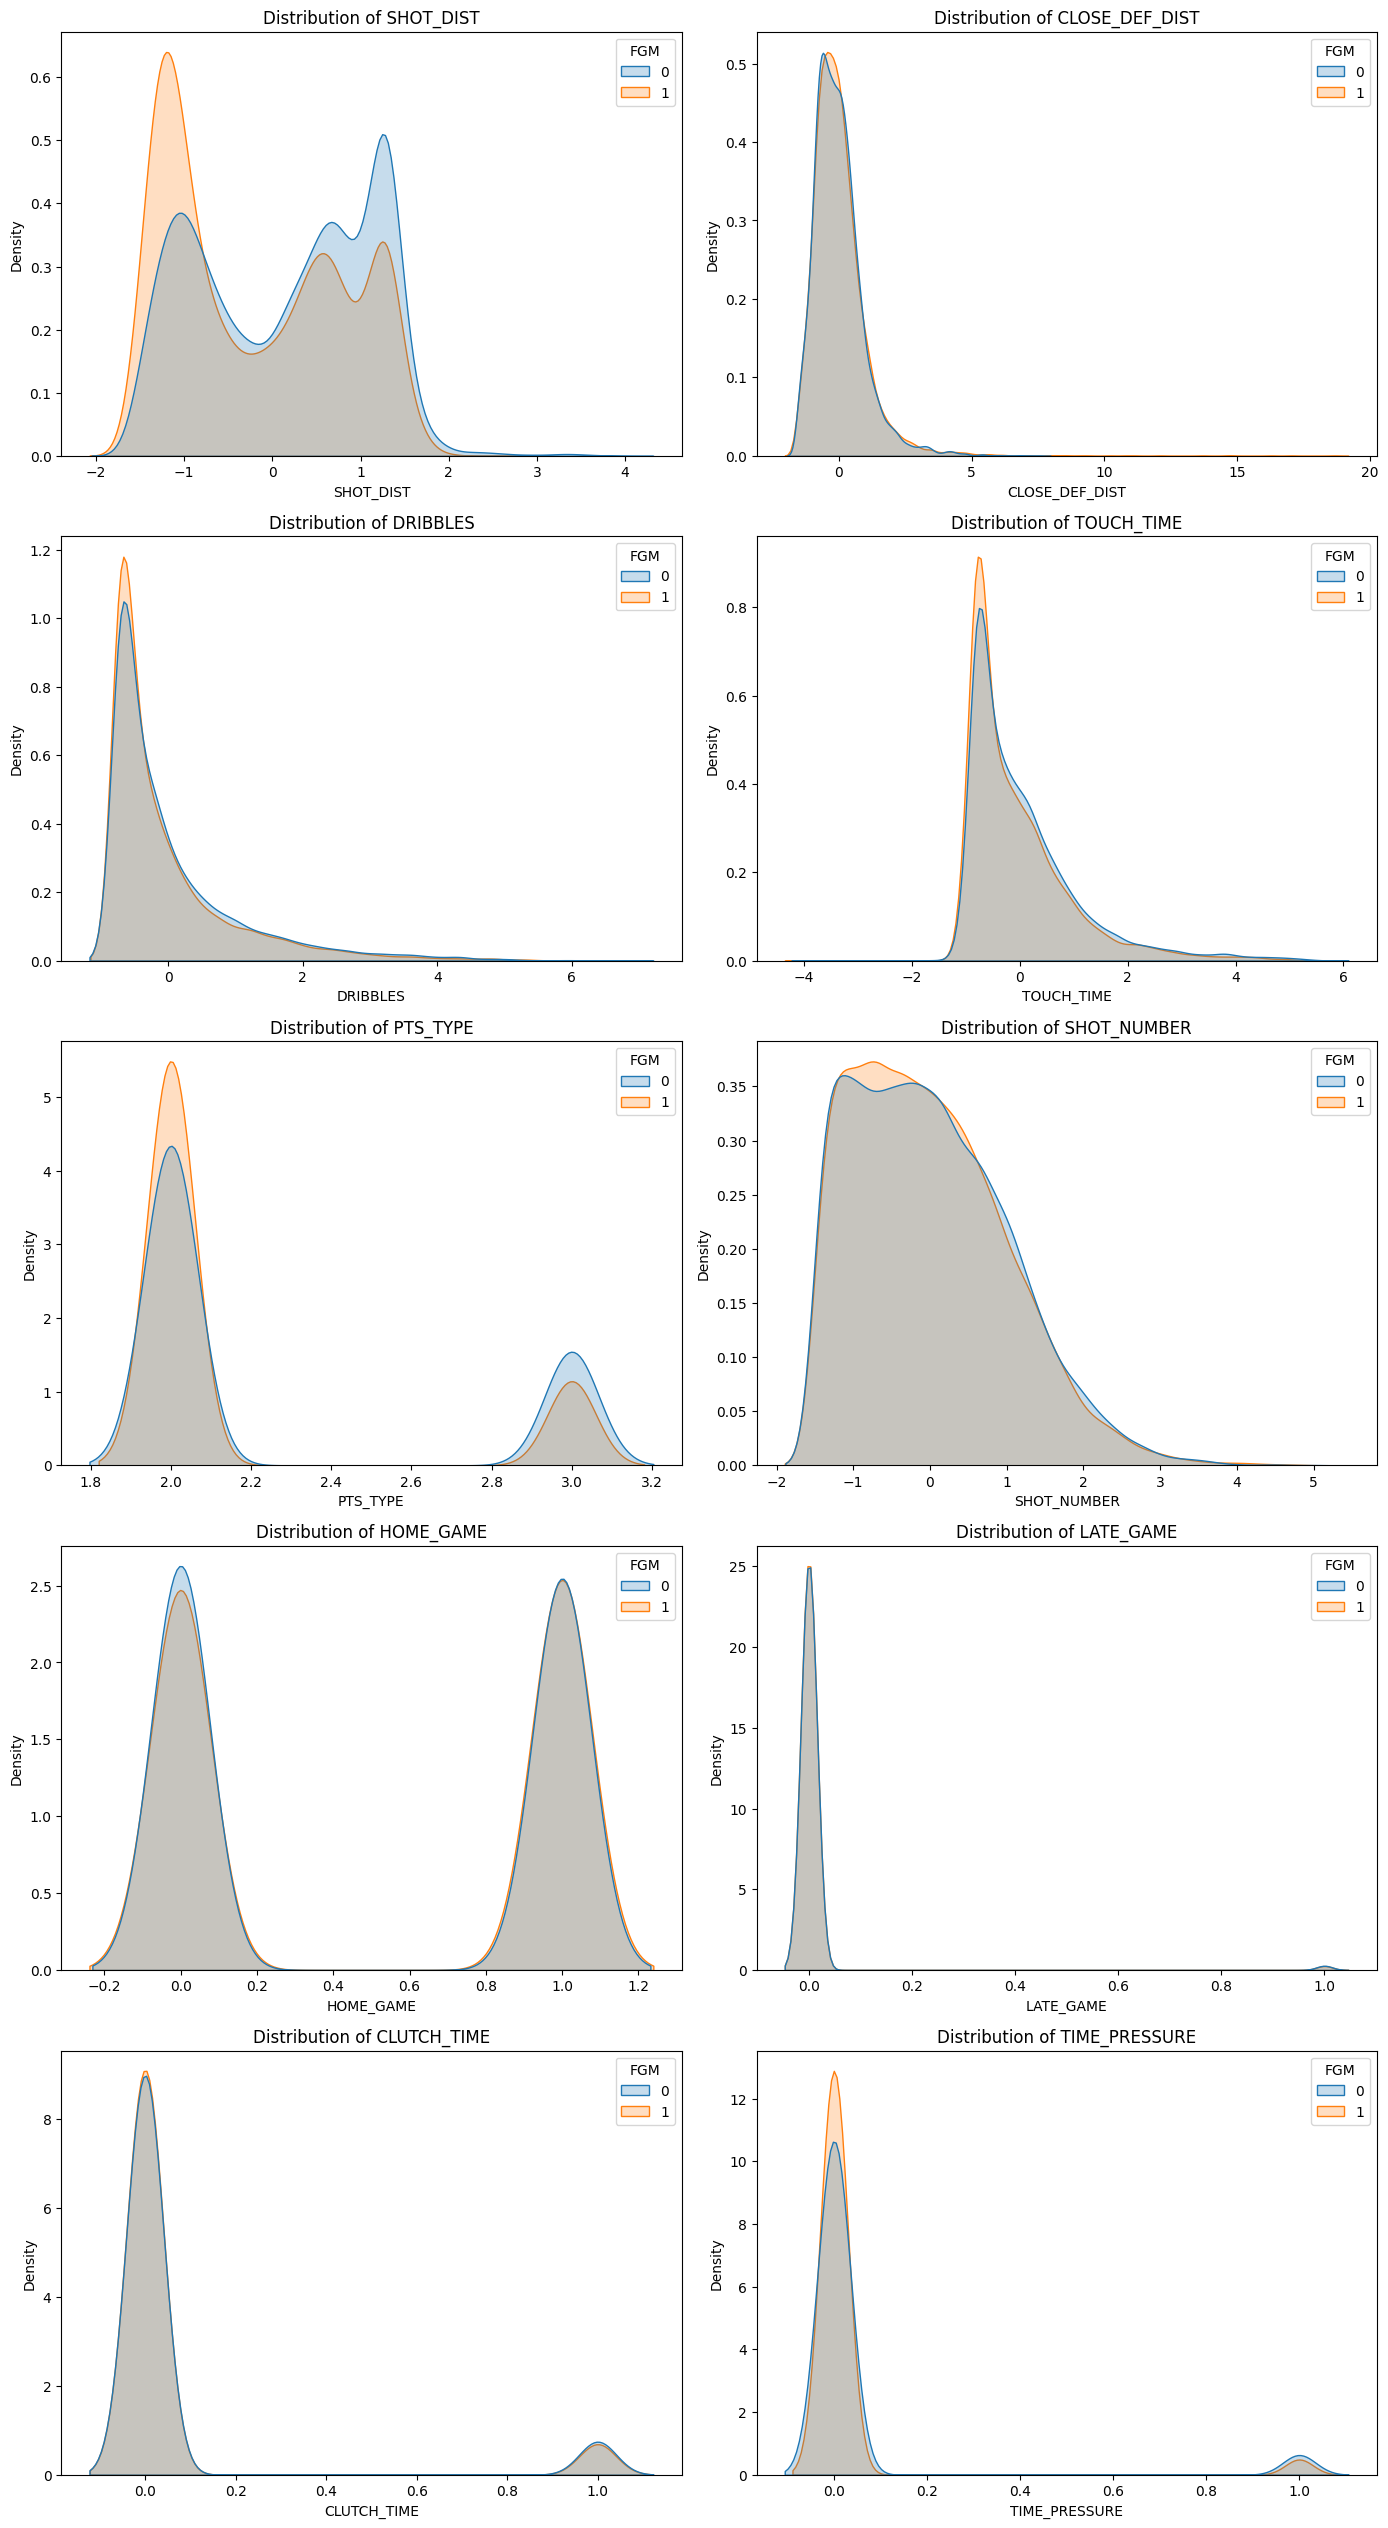

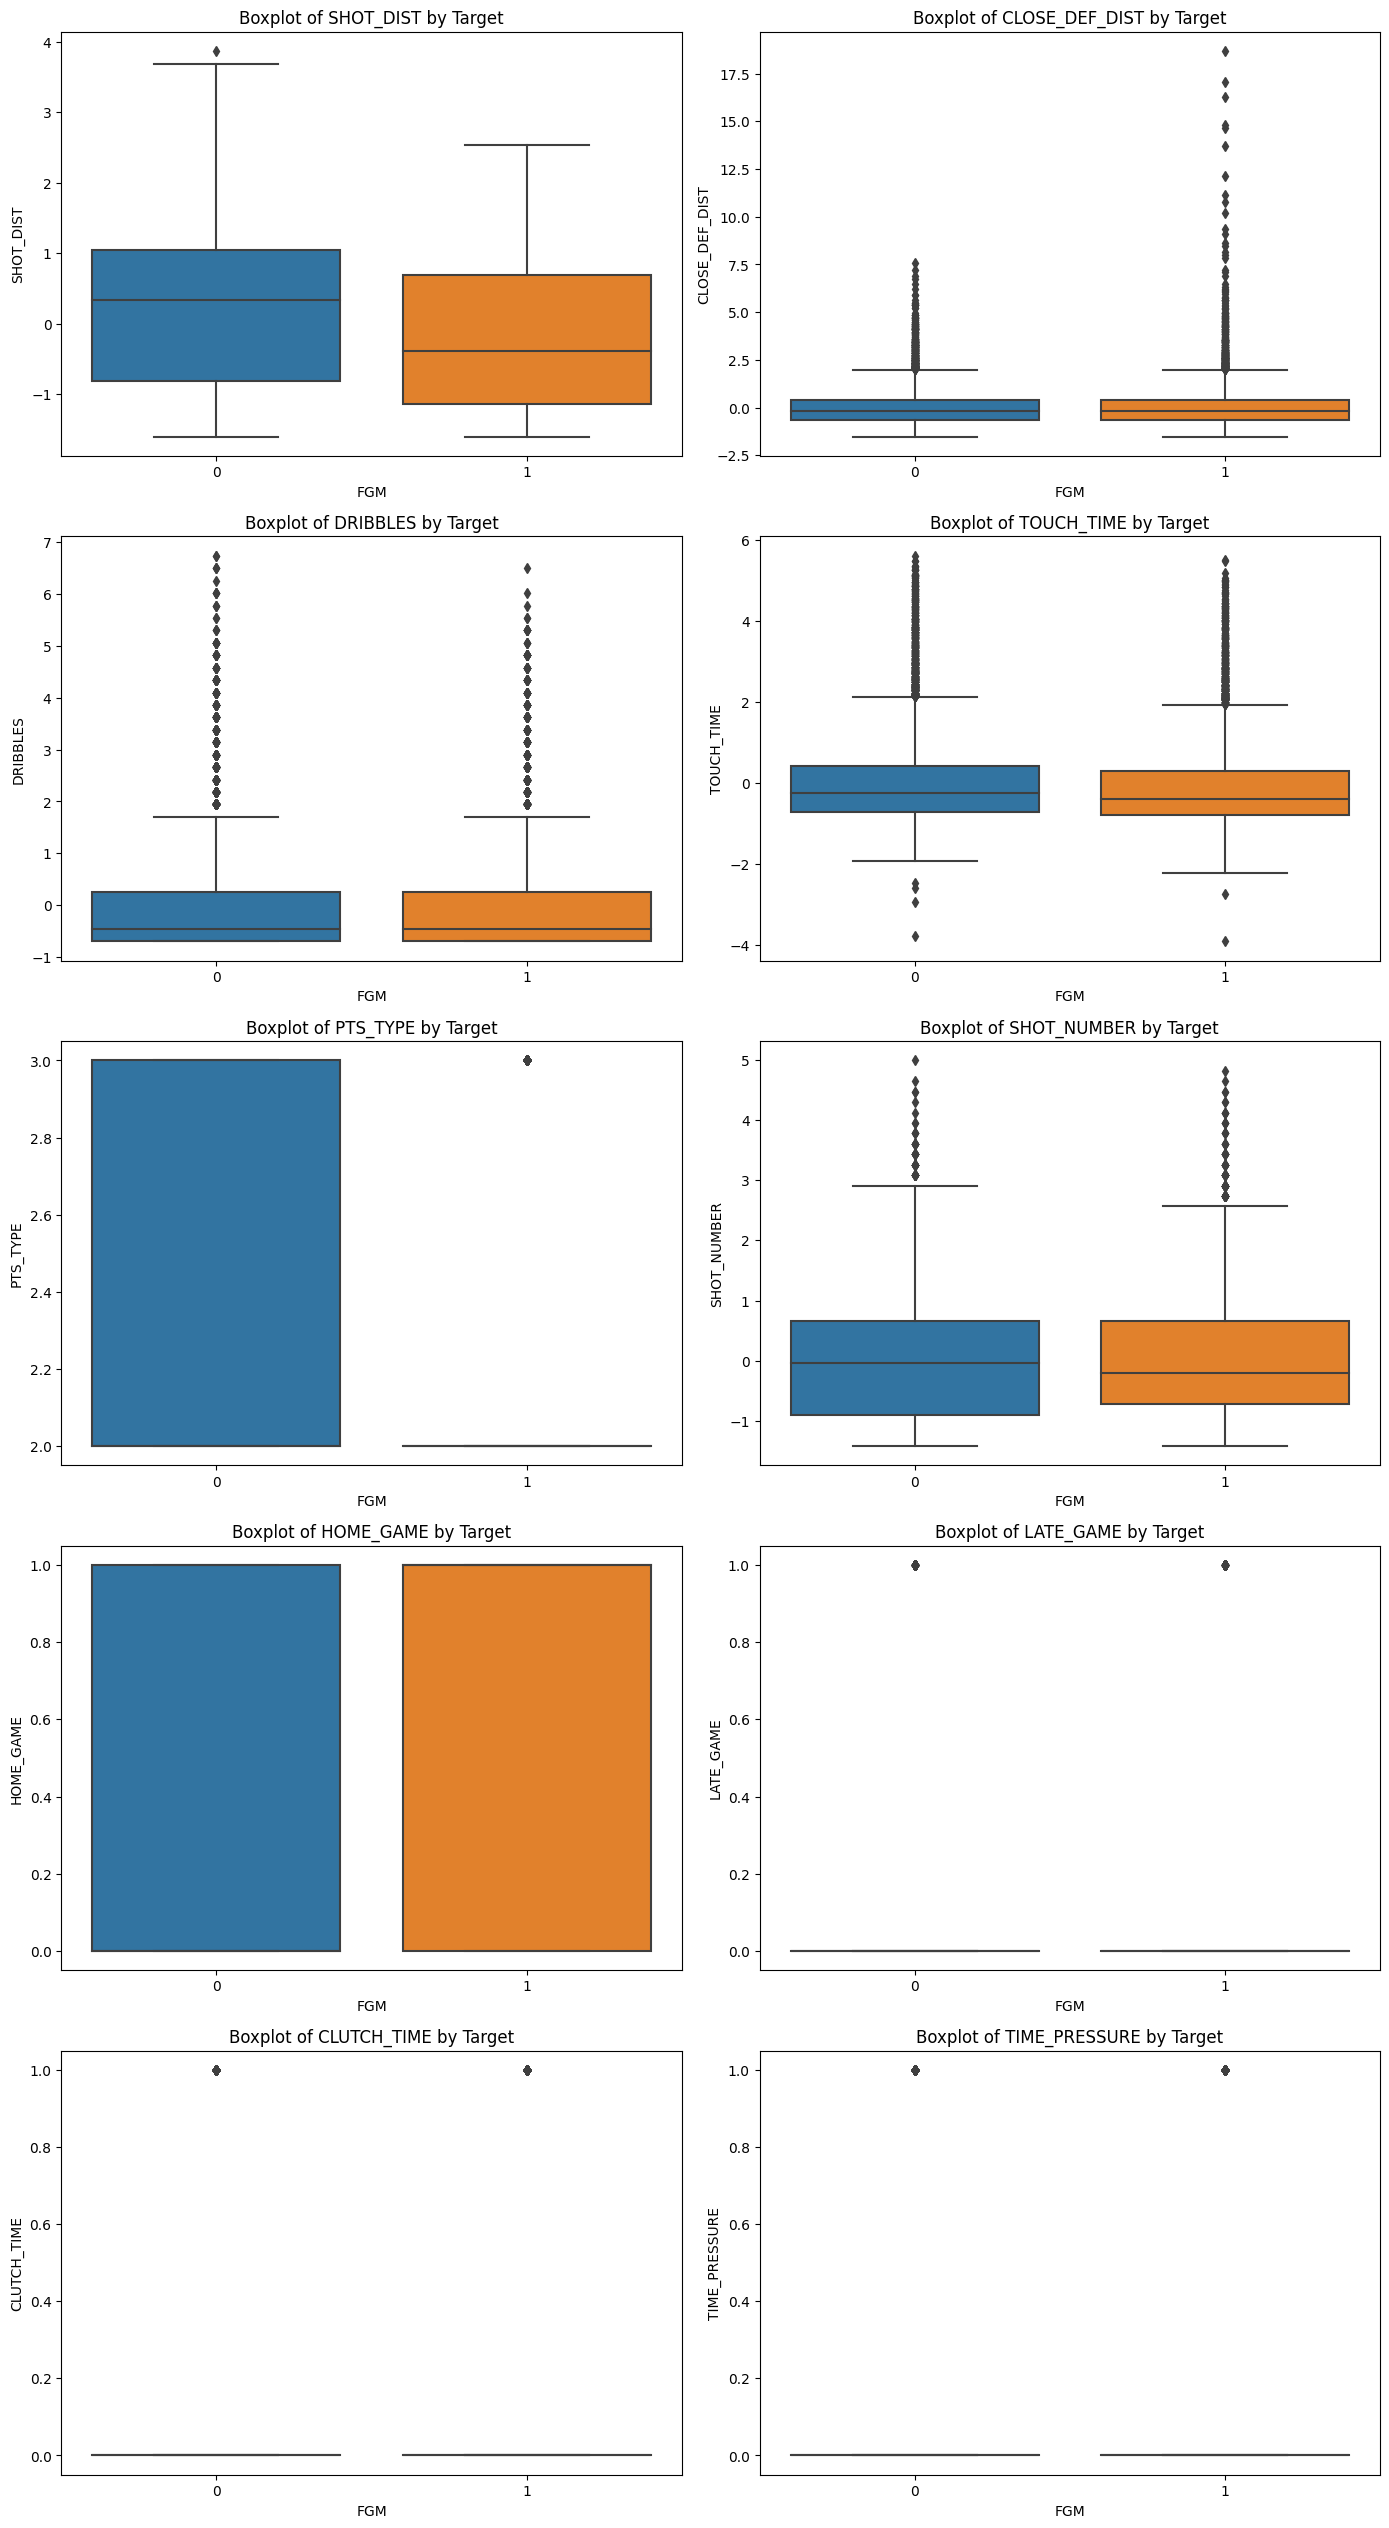

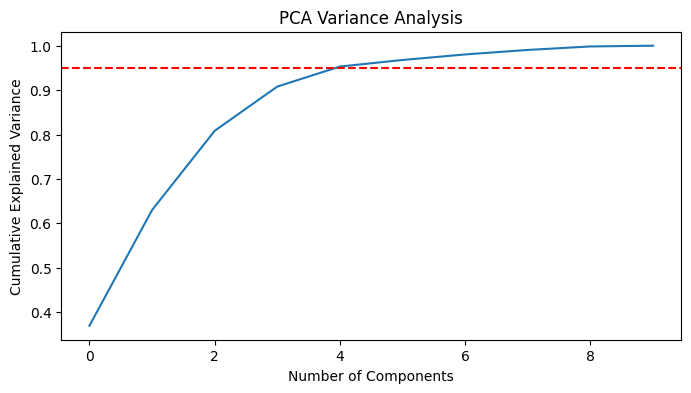

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif
from scipy import stats

# 2. Multikollinearitätsprüfung mit VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) 
                       for i in range(len(df.columns))]
    return vif_data.sort_values("VIF", ascending=False)

vif_results = calculate_vif(train_df[features])
print("Variance Inflation Factors:")
print(vif_results)
print("\n\n")

# 3. Mutual Information mit Target
mi_scores = mutual_info_classif(train_df[features], train_df[target], random_state=42)
mi_df = pd.DataFrame({"Feature": features, "MI_Score": mi_scores}) \
         .sort_values("MI_Score", ascending=False)
print(mi_df)

plt.figure(figsize=(10,6))
sns.barplot(x="MI_Score", y="Feature", data=mi_df, palette="viridis")
plt.title("Mutual Information with Target Variable")
plt.show()

# 4. Statistische Signifikanz (t-test für kontinuierliche Features)
def check_feature_significance(df, features, target):
    results = []
    for feature in features:
        group1 = df[df[target]==1][feature]
        group0 = df[df[target]==0][feature]
        t_stat, p_val = stats.ttest_ind(group1, group0, equal_var=False)
        results.append({
            "Feature": feature,
            "Mean_1": group1.mean(),
            "Mean_0": group0.mean(),
            "T-statistic": t_stat,
            "P-value": p_val
        })
    return pd.DataFrame(results).sort_values("P-value")

sig_results = check_feature_significance(train_df, features, target)
print("\nStatistical Significance Tests:")
print(sig_results)

# 5. Feature Distribution Plots
plt.figure(figsize=(14, len(features)*3))
for i, feature in enumerate(features, 1):
    plt.subplot(len(features)//2 + 1, 2, i)
    sns.kdeplot(data=train_df, x=feature, hue=target, fill=True, common_norm=False)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

# 6. Boxplots für Ausreißeranalyse
plt.figure(figsize=(14, len(features)*3))
for i, feature in enumerate(features, 1):
    plt.subplot(len(features)//2 + 1, 2, i)
    sns.boxplot(x=target, y=feature, data=train_df)
    plt.title(f"Boxplot of {feature} by Target")
plt.tight_layout()
plt.show()

# 7. PCA-Varianzanalyse (optional)
from sklearn.decomposition import PCA

pca = PCA().fit(train_df[features])
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title("PCA Variance Analysis")
plt.show()

## 4. Probabilistic Modeling Approach

- Description of the models chosen
- Why they are suitable for your problem
- Mathematical formulations (if applicable)



## Hierarchical Logistic Regression Model: Mathematical Formulation

### Model Specification

The hierarchical logistic regression models shot success probability $p_{ij}$ for player $j$ on shot attempt $i$ as:

$
p_{ij} = \frac{1}{1 + e^{-\eta_{ij}}}
$

where the linear predictor $\eta_{ij}$ combines player-specific effects:

$
\eta_{ij} = \alpha_j + \sum_{k=1}^{K} \beta_{jk} x_{ijk}
$

### Hierarchical Structure

#### Player-Specific Parameters
- **Intercepts**: $\alpha_j \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha^2)$  
  Each player has a baseline shooting ability (log-odds) drawn from a population distribution.

- **Coefficients**: $\beta_{jk} \sim \mathcal{N}(\mu_{\beta_k}, \sigma_{\beta_k}^2)$  
  Feature effects vary by player, with:
  - $\mu_{\beta_k}$: Average effect of feature $k$ across players
  - $\sigma_{\beta_k}$: Between-player variability in feature importance

#### Hyperpriors
\begin{aligned}
\mu_\alpha &\sim \mathcal{N}(0, 1) \\
\sigma_\alpha &\sim \mathcal{HN}(1) \\
\mu_{\beta_k} &\sim \mathcal{N}(0, 1) \\
\sigma_{\beta_k} &\sim \mathcal{HN}(1) \\
\end{aligned}

where $\mathcal{HN}$ denotes the half-normal distribution.

### Justification for Model Choice

1. **Hierarchical Structure**:
   - Accounts for nested data (shots within players)
   - Enables partial pooling - estimates for low-volume shooters borrow strength from the population
   - Quantifies between-player heterogeneity in shooting characteristics

2. **Logistic Regression**:
   - Natural choice for binary outcomes (make/miss)
   - Interpretable coefficients (log-odds ratios)
   - Well-calibrated probability outputs

3. **Bayesian Approach**:
   - Naturally handles uncertainty in player-level estimates
   - Provides full posterior distributions for all parameters
   - Enables direct probability statements about effects

### Key Mathematical Components

1. **Likelihood**:
   $
   y_{ij} \sim \text{Bernoulli}(p_{ij})
   $
   
2. **Partial Pooling**:
   The strength of shrinkage toward population means is data-dependent:
   $
   \hat{\beta}_{jk} \approx \frac{n_j}{\sigma_{\beta_k}^2} \bar{\beta}_j + \frac{1}{\sigma_{\beta_k}^2} \mu_{\beta_k}
   $
   where $n_j$ is the number of shots for player $j$.

3. **Covariate Effects**:
   For a unit increase in standardized feature $x_k$, the odds ratio changes by:
   $
   \exp(\beta_{jk}) \text{ for player } j
   $
   with population-average effect $\exp(\mu_{\beta_k})$.

### Implementation Details

- **Preprocessing**:
  - Continuous features standardized ($z$-scores)
  - Categorical features one-hot encoded
  - Player IDs converted to indices for hierarchical modeling

- **Computation**:
  - Hamiltonian Monte Carlo sampling (NUTS)
  - 4 chains with 1500 samples each (700 tune)
  - Target acceptance rate 0.9 for reliable sampling

- **Model Checking**:
  - Prior predictive checks verify reasonable initial assumptions
  - Posterior predictive checks assess model fit
  - $\hat{R}$ statistics monitor convergence

This formulation explicitly models the multilevel structure of NBA shooting data while providing interpretable, player-specific estimates of shooting characteristics.

# 5. Model Training and Alternative Modelling-Aproaches

### 5.1 Feature Selection:

In [17]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# load data:
shot_logs = pd.read_csv('../data/shot_logs_modified.csv')

# === Feature & Target Definition ===
features = [
    'SHOT_DIST', 'CLOSE_DEF_DIST', 'DRIBBLES', 'TOUCH_TIME',
    'PTS_TYPE', 'SHOT_NUMBER', 'HOME_GAME', 'LATE_GAME',
    'CLUTCH_TIME', 'TIME_PRESSURE',

    'RESTRICTED_AREA', 'PAINT', 'MID_RANGE', '3PT',
]

target = 'FGM'

# numerical features to be standardized
standardize_features = [
    'SHOT_DIST', 'CLOSE_DEF_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_NUMBER',  
]

# === Standardize ===
scaler = StandardScaler()
shot_logs[standardize_features] = scaler.fit_transform(shot_logs[standardize_features])

X_scaled = shot_logs[features]
y = shot_logs[target]

In [19]:
# === Feature Importance via Random Forest ===
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_scaled, y)
rf_importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
rf_top10 = rf_importances.head(10).index.tolist()
print("\n=== Random Forest Feature Importances ===")
print("All features sorted by importance:")
print("---------------------------------")
for feature, importance in rf_importances.items():
    print(f"{feature}: {importance:.4f}")

# === Zusammenfassung ===
print("\n\n\nTop 10 Features via Random Forest:\n", rf_top10)


=== Random Forest Feature Importances ===
All features sorted by importance:
---------------------------------
CLOSE_DEF_DIST: 0.2585
SHOT_DIST: 0.2565
TOUCH_TIME: 0.2083
SHOT_NUMBER: 0.1602
DRIBBLES: 0.0607
RESTRICTED_AREA: 0.0150
HOME_GAME: 0.0148
PTS_TYPE: 0.0064
CLUTCH_TIME: 0.0055
TIME_PRESSURE: 0.0046
MID_RANGE: 0.0029
3PT: 0.0026
PAINT: 0.0021
LATE_GAME: 0.0018



Top 10 Features via Random Forest:
 ['CLOSE_DEF_DIST', 'SHOT_DIST', 'TOUCH_TIME', 'SHOT_NUMBER', 'DRIBBLES', 'RESTRICTED_AREA', 'HOME_GAME', 'PTS_TYPE', 'CLUTCH_TIME', 'TIME_PRESSURE']


### 5.2 Data Preparation For Modeling

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import xarray as xr

# Set random seed for reproducibility
np.random.seed(42)

# load data:
df = pd.read_csv('../data/shot_logs_modified.csv')

In [21]:
# Count shot attempts per player
player_shot_counts = df['player_id'].value_counts()

# Get top 30 player IDs
top_30_players = player_shot_counts.head(30).index.tolist()

# Filter dataset for only these players
df_top30 = df[df['player_id'].isin(top_30_players)].copy()

In [22]:
# -------------------------------------------
# Feature-Liste + Zielvariable
# -------------------------------------------

features = [
    'SHOT_DIST', 
    'CLOSE_DEF_DIST', 
    'DRIBBLES', 
    'TOUCH_TIME',
    'PTS_TYPE', 
    'SHOT_NUMBER', 
    'HOME_GAME', 
    'LATE_GAME',   #'RESTRICTED_AREA'
    'CLUTCH_TIME', 
    'TIME_PRESSURE'
]

# Target variable
target = 'FGM'

# Get unique player IDs (of top 30 players with the most shot attempts) for hierarchical modeling
player_ids = df_top30['player_id'].unique()
n_players = len(player_ids)
player_idx = df_top30['player_id'].astype('category').cat.codes.values

# Split data into train and test sets
train_df, test_df = train_test_split(df_top30, test_size=0.2, random_state=42, stratify=df_top30[target])

# Standardize continuous features (except distance which has meaningful zero)
scaler = StandardScaler()
scale_cols = [ 'SHOT_DIST', 'CLOSE_DEF_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_NUMBER' ]
train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])
test_df[scale_cols] = scaler.transform(test_df[scale_cols])

# Prepare data arrays for PyMC
X_train = train_df[features].values
y_train = train_df[target].values
player_idx_train = train_df['player_id'].astype('category').cat.codes.values

X_test = test_df[features].values
y_test = test_df[target].values
player_idx_test = test_df['player_id'].astype('category').cat.codes.values

### 5.3 Bayesian Logistic Regression Model

In [23]:
with pm.Model() as hierarchical_logistic_model:
    # Hyperpriors for group-level parameters
    mu_a = pm.Normal('mu_a', mu=0, sigma=1)
    sigma_a = pm.HalfNormal('sigma_a', sigma=1)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=1, shape=len(features))
    sigma_b = pm.HalfNormal('sigma_b', sigma=1, shape=len(features))
    
    # Player-specific intercepts and coefficients
    a_player = pm.Normal('a_player', mu=mu_a, sigma=sigma_a, shape=n_players)
    b_player = pm.Normal('b_player', mu=mu_b, sigma=sigma_b, shape=(n_players, len(features)))

    # Model error
    eps = pm.HalfNormal('eps', sigma=1)
    
    # Linear predictor
    logit_p = a_player[player_idx_train]
    for i in range(len(features)):
        logit_p += b_player[player_idx_train, i] * X_train[:, i]
    
    # Likelihood
    y_pred = pm.Bernoulli('y_pred', logit_p=logit_p, observed=y_train)

    # Prior predictive check
    prior_checks = pm.sample_prior_predictive()

    # Fit the model
    trace = pm.sample(1500, tune=700, chains=4, target_accept=0.9, return_inferencedata=True)
    # Save trace
    az.to_netcdf(trace, 'nba_shooting_trace2.nc')

    
    # Posterior predictive checks
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=['y_pred'])

Sampling: [a_player, b_player, eps, mu_a, mu_b, sigma_a, sigma_b, y_pred]
Sampling: [y_pred]


In [ ]:
# Load Trace
trace = az.from_netcdf('nba_shooting_trace.nc')

In [ ]:
az.summary(trace)

In [25]:
# Extrahiere Mittelwerte der Posterior-Samples (z.B. für Point Estimates)
mean_a_player = trace.posterior['a_player'].mean(dim=('chain', 'draw')).values
mean_b_player = trace.posterior['b_player'].mean(dim=('chain', 'draw')).values

# Berechne Logits für den Testset
logits_test = mean_a_player[player_idx_test]
for i in range(len(features)):
    logits_test += mean_b_player[player_idx_test, i] * X_test[:, i]

# Sigmoid → Wahrscheinlichkeiten
probs_test = 1 / (1 + np.exp(-logits_test))

# Threshold (z.B. 0.5)
y_pred_test = (probs_test >= 0.5).astype(int)

# Metriken
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))

Accuracy: 0.5917906232347957
Precision: 0.5915208613728129
Recall: 0.3602459016393443
F1 Score: 0.44778400407539487


### 5.4 New Modelling-Approaches

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import xarray as xr
np.random.seed(42)

# load data:
df = pd.read_csv('../data/shot_logs_modified.csv')

# Count shot attempts per player
player_shot_counts = df['player_id'].value_counts()
# Get top 30 player IDs
top_30_players = player_shot_counts.head(30).index.tolist()
# Filter dataset for only these players
df_top30 = df[df['player_id'].isin(top_30_players)].copy()

#### 5.4.1 More Advanced Feature Engeneering and Feature Selection

In [43]:
# -------------------------------------------
# 1. Feature Engineering – neue manuelle Features
# -------------------------------------------

df_top30['SHOT_RATIO'] = df_top30['SHOT_DIST'] / (df_top30['CLOSE_DEF_DIST'] + 1e-3)
df_top30['DRIBBLE_SPEED'] = df_top30['TOUCH_TIME'] / (df_top30['DRIBBLES'] + 1e-3)
# Defensive pressure: Distance adjusted by shot type
df_top30['DEF_PRESSURE'] = df_top30['CLOSE_DEF_DIST'] / df_top30['PTS_TYPE']
# Quickness of Action: Ratio of time of possession and dribbles done
df_top30['TOUCH_PER_DRIBBLE'] = df_top30['TOUCH_TIME'] / (df_top30['DRIBBLES'] + 1e-3)
# Effektive Entfernung: Shot distance + defensive proximity
df_top30['EFFECTIVE_SHOT_DIST'] = df_top30['SHOT_DIST'] + (1 / (df_top30['CLOSE_DEF_DIST'] + 1e-3))
# Threes taken multiple steps behind three point line
df_top30['IS_LONG_3PT'] = ((df_top30['PTS_TYPE'] == 3) & (df_top30['SHOT_DIST'] > 25)).astype(int)
# Shot under pressure (combination of defensive pressure and temporal pressure)
df_top30['UNDER_PRESSURE'] = ((df_top30['CLOSE_DEF_DIST'] < 3) & (df_top30['TIME_PRESSURE'] == 1)).astype(int)
# Shot early in the possession
df_top30['EARLY_SHOT'] = (df_top30['SHOT_CLOCK'] > 18).astype(int)
# shot taken at the end of shot-clock (bail-out shot attempt)
df_top30['LATE_CLOCK'] = (df_top30['SHOT_CLOCK'] < 5).astype(int)
# Momentum indicator: true when previous shot was successful
df_top30.sort_values(by=['player_id', 'GAME_ID', 'SHOT_NUMBER'], inplace=True)
df_top30['PREV_SHOT_MADE'] = df_top30.groupby(['player_id'])['FGM'].shift(1).fillna(0)
# fatique indicator: shot taken in first half?
df_top30['FIRST_HALF'] = (df_top30['PERIOD'] <= 2).astype(int)
# Overtime Indicator
df_top30['IS_OVERTIME'] = (df_top30['PERIOD'] > 4).astype(int)
# ratio of dribbles performed and shot distance
df_top30['DIST_PER_DRIBBLE'] = df_top30['SHOT_DIST'] / (df_top30['DRIBBLES'] + 1e-3)

# ----------------------------------------------
# 2. Advanced Feature Engineering
# ----------------------------------------------

# Advanced basketball metrics
df_top30['SHOT_ANGLE'] = np.arctan(df_top30['SHOT_DIST']/10)  # Basket height ~10ft
df_top30['SHOT_DIFFICULTY'] = ((df_top30['SHOT_DIST'] * np.log1p(df_top30['DRIBBLES'])) / 
                             (df_top30['CLOSE_DEF_DIST'] + 1))

# Average Field-Goal Percentage over the last 10 taken shots
df_top30.sort_values(by=['player_id', 'GAME_ID', 'SHOT_NUMBER'], inplace=True)
df_top30['ROLLING_FG_PCT'] = df_top30.groupby('player_id')['FGM'].transform(
    lambda x: x.shift(1).rolling(10, min_periods=1).mean())
df_top30['ROLLING_FG_PCT'] = df_top30['ROLLING_FG_PCT'].fillna(0)

# Create IS_HOT flag (True if last 3 shots were successfull
df_top30.sort_values(['player_id', 'GAME_ID', 'SHOT_NUMBER'], inplace=True)
df_top30['LAST_3_MAKES'] = df_top30.groupby('player_id')['FGM'] \
                                 .transform(lambda x: x.shift(1).rolling(3, min_periods=1).sum())
df_top30['IS_HOT'] = (df_top30['LAST_3_MAKES'] >= 3).astype(int)
df_top30.drop('LAST_3_MAKES', axis=1, inplace=True)
df_top30['IS_HOT'] = df_top30['IS_HOT'].fillna(0)

##### Smart field goal percentage:

Creating the features SMART_2P_PCT and SMART_3P_PCT that provide adaptive, context-aware shooting percentages for NBA players. They combine:
- A player’s career average (2P% or 3P%) as a baseline
- In-game performance once a player has taken ≥3 shots

If fewer than 3 attempts are made, the career average ensures stability. This prevents misleading early-game percentages while dynamically adjusting to real-time performance. If more than 3 attempts were taken the field-goal percentage for all shots taken from beyond the 3-point line is calculated and stored in the feature SMART_3P_PCT. The same counts for the feature SMART_2P_PCT, where the field goal percentage for all 2-point shots is derived once more than 3 two-point shots were taken in the respective game. 

In [44]:
# 1. First calculate career averages for each player by shot type
career_2p = df_top30[df_top30['PTS_TYPE'] == 2].groupby('player_id')['FGM'].mean().to_dict()
career_3p = df_top30[df_top30['PTS_TYPE'] == 3].groupby('player_id')['FGM'].mean().to_dict()

# 2. Calculate cumulative attempts and makes by shot type per game
df_top30.sort_values(['player_id', 'GAME_ID', 'SHOT_NUMBER'], inplace=True)

# Initialize columns
df_top30['2P_ATTEMPTS_IN_GAME'] = 0
df_top30['2P_MAKES_IN_GAME'] = 0 
df_top30['3P_ATTEMPTS_IN_GAME'] = 0
df_top30['3P_MAKES_IN_GAME'] = 0

# Calculate cumulative counts
for pts_type in [2, 3]:
    mask = df_top30['PTS_TYPE'] == pts_type
    df_top30.loc[mask, f'{pts_type}P_ATTEMPTS_IN_GAME'] = df_top30[mask].groupby(
        ['player_id', 'GAME_ID']).cumcount()
    df_top30.loc[mask, f'{pts_type}P_MAKES_IN_GAME'] = df_top30[mask].groupby(
        ['player_id', 'GAME_ID'])['FGM'].shift(1).cumsum()

# 3. Create smart percentage features
def get_smart_fgp(row):
    if row['PTS_TYPE'] == 2:
        attempts = row['2P_ATTEMPTS_IN_GAME']
        makes = row['2P_MAKES_IN_GAME']
        career_pct = career_2p.get(row['player_id'], 0.45)
    else:
        attempts = row['3P_ATTEMPTS_IN_GAME']
        makes = row['3P_MAKES_IN_GAME']
        career_pct = career_3p.get(row['player_id'], 0.35)
    
    return makes/attempts if attempts >= 3 else career_pct

df_top30['SMART_FGP'] = df_top30.apply(get_smart_fgp, axis=1)

# 4. Create separate features for 2P and 3P percentages
df_top30['SMART_2P_PCT'] = np.where(
    df_top30['PTS_TYPE'] == 2,
    df_top30['SMART_FGP'],
    df_top30['player_id'].map(career_2p).fillna(0.45)
)
df_top30['SMART_3P_PCT'] = np.where(
    df_top30['PTS_TYPE'] == 3,
    df_top30['SMART_FGP'], 
    df_top30['player_id'].map(career_3p).fillna(0.35)
)

# Cleanup - remove intermediate columns
df_top30.drop([
    '2P_ATTEMPTS_IN_GAME', '2P_MAKES_IN_GAME',
    '3P_ATTEMPTS_IN_GAME', '3P_MAKES_IN_GAME',
    'SMART_FGP'
], axis=1, inplace=True)

In [45]:
# storing feature engeneered dataframe to new csv-file
df_top30.to_csv('../data/shot_logs_advanced_modified.csv', index=False)

<br>
<br>

##### Feature Selection (with ANOVA, RFE, Random Forest Feature Importance and Lasso Regularization):

In [46]:
df = pd.read_csv('../data/shot_logs_advanced_modified.csv')

In [47]:
# === Feature & Target Definition ===
features = [
    'SHOT_DIST', 'CLOSE_DEF_DIST', 'DRIBBLES', 'TOUCH_TIME',
    'PTS_TYPE', 'SHOT_NUMBER', 'HOME_GAME', 'LATE_GAME',
    'CLUTCH_TIME', 'TIME_PRESSURE',

    'RESTRICTED_AREA', 'PAINT', 'MID_RANGE', '3PT',
    
    'SHOT_RATIO', 'DRIBBLE_SPEED', 'DEF_PRESSURE', 'TOUCH_PER_DRIBBLE',
    'EFFECTIVE_SHOT_DIST', 'IS_LONG_3PT', 'UNDER_PRESSURE',
    'EARLY_SHOT', 'LATE_CLOCK', 'DIST_PER_DRIBBLE',
    'PREV_SHOT_MADE', 'FIRST_HALF', 'IS_OVERTIME',

    'SMART_2P_PCT', 'SMART_3P_PCT', 'SHOT_ANGLE', 'SHOT_DIFFICULTY',
    'ROLLING_FG_PCT', 'IS_HOT'
]

target = 'FGM'

# numerical features to be standardized
standardize_features = [
    'SHOT_DIST', 'CLOSE_DEF_DIST', 'DRIBBLES', 'TOUCH_TIME',
    'SHOT_NUMBER',
    
    'SHOT_RATIO', 'DRIBBLE_SPEED', 'DEF_PRESSURE', 'TOUCH_PER_DRIBBLE',
    'EFFECTIVE_SHOT_DIST', 'DIST_PER_DRIBBLE',

    'SMART_2P_PCT', 'SMART_3P_PCT', 'SHOT_ANGLE', 'SHOT_DIFFICULTY',
    'ROLLING_FG_PCT'  
]

# === Standardize ===
scaler = StandardScaler()
df[standardize_features] = scaler.fit_transform(df[standardize_features])


X_scaled = df[features]
y = df[target]

# === 1. SelectKBest (Univariate ANOVA F-test) ===
k_best = SelectKBest(score_func=f_classif, k=10)
k_best.fit(X_scaled, y)
kbest_features = [features[i] for i in k_best.get_support(indices=True)]

# === 2. Recursive Feature Elimination (RFE) ===
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X_scaled, y)
rfe_features = [features[i] for i in range(len(features)) if rfe.support_[i]]

# === 3. Feature Importance via Random Forest ===
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_scaled, y)
rf_importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
rf_top10 = rf_importances.head(10).index.tolist()

# === 4. Lasso Regularization ===
lasso = LassoCV(
    alphas=np.logspace(-3, 0, 50),  # Mittlerer Bereich (0.001 bis 1)
    cv=5,
    max_iter=50000,
    n_jobs=-1,
    tol=1e-4
).fit(X_scaled, y)
coeffs = pd.Series(lasso.coef_, index=features)
mean_effect_size = np.abs(coeffs).mean()  # Mittlere Effektstärke
threshold = 0.2 * mean_effect_size
lasso_selected = coeffs[np.abs(coeffs) > threshold].index.tolist()


# === Zusammenfassung ===
print("Top 10 Features via SelectKBest:", kbest_features)
print("\n")
print("Top 10 Features via RFE:", rfe_features)
print("\n")
print("Top 10 Features via Random Forest:", rf_top10)
print("\n")
print("Lasso-gewählte Features:", lasso_selected)

# Optional: Features nehmen, die bei mindestens 2 Methoden vorkommen
from collections import Counter
all_selected = kbest_features + rfe_features + rf_top10 + lasso_selected
feature_counts = Counter(all_selected)
final_features = [f for f, count in feature_counts.items() if count >= 3]

print("\nEmpfohlene finale Features (mind. 3x ausgewählt):")
print(final_features)

Top 10 Features via SelectKBest: ['SHOT_DIST', 'PTS_TYPE', 'RESTRICTED_AREA', 'MID_RANGE', '3PT', 'IS_LONG_3PT', 'EARLY_SHOT', 'LATE_CLOCK', 'SHOT_ANGLE', 'SHOT_DIFFICULTY']


Top 10 Features via RFE: ['SHOT_DIST', 'CLOSE_DEF_DIST', 'PTS_TYPE', 'RESTRICTED_AREA', 'PAINT', 'MID_RANGE', '3PT', 'DEF_PRESSURE', 'UNDER_PRESSURE', 'LATE_CLOCK']


Top 10 Features via Random Forest: ['SHOT_RATIO', 'EFFECTIVE_SHOT_DIST', 'SMART_2P_PCT', 'DIST_PER_DRIBBLE', 'SHOT_DIST', 'DEF_PRESSURE', 'TOUCH_PER_DRIBBLE', 'DRIBBLE_SPEED', 'CLOSE_DEF_DIST', 'TOUCH_TIME']


Lasso-gewählte Features: ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'PTS_TYPE', 'HOME_GAME', 'CLUTCH_TIME', 'RESTRICTED_AREA', 'PAINT', '3PT', 'DEF_PRESSURE', 'UNDER_PRESSURE', 'EARLY_SHOT', 'LATE_CLOCK', 'PREV_SHOT_MADE', 'SHOT_ANGLE']

Empfohlene finale Features (mind. 3x ausgewählt):
['SHOT_DIST', 'PTS_TYPE', 'RESTRICTED_AREA', '3PT', 'LATE_CLOCK', 'DEF_PRESSURE']


<br>
<br>

#### 5.4.2 Benchmark Models

In [66]:
df = pd.read_csv('../data/shot_logs_advanced_modified.csv')

# Filter top 30 players by shot attempts
top_30_players = df['player_id'].value_counts().head(30).index.tolist()
df_top30 = df[df['player_id'].isin(top_30_players)].copy()

In [67]:
features = [
    'SHOT_DIST', 
    'RESTRICTED_AREA', 
    '3PT', 
    'SMART_2P_PCT', 
    'SMART_3P_PCT', 
    'SHOT_ANGLE',
    'LATE_CLOCK',
    'DEF_PRESSURE',
    'CLUTCH_TIME',
    #'CLOSE_DEF_DIST', 'DRIBBLES', 'TOUCH_TIME', 'PTS_TYPE', 'SHOT_NUMBER', 'HOME_GAME', 'LATE_GAME',
    #'TIME_PRESSURE','SHOT_RATIO', 'DRIBBLE_SPEED', 'TOUCH_PER_DRIBBLE', 'EFFECTIVE_SHOT_DIST', 'IS_OVERTIME',
    #'IS_LONG_3PT', 'UNDER_PRESSURE', 'EARLY_SHOT', 'DIST_PER_DRIBBLE', 'PREV_SHOT_MADE', 'FIRST_HALF' 
]

target = 'FGM'

standardize_features = [
    'SHOT_DIST',
    'CLOSE_DEF_DIST', 
    'SHOT_ANGLE',
    'DRIBBLES', 
    'TOUCH_TIME',
    'SMART_2P_PCT', 
    'SMART_3P_PCT',
    'DEF_PRESSURE',
    'DIST_PER_DRIBBLE',
]

# ----------------------------
# 4. Data Splitting & Scaling
# ----------------------------
print("Preparing train/test split...")

# Split by game to prevent leakage
game_ids = df_top30['GAME_ID'].unique()
train_games, test_games = train_test_split(game_ids, test_size=0.2, random_state=42)

train_df = df_top30[df_top30['GAME_ID'].isin(train_games)]
test_df = df_top30[df_top30['GAME_ID'].isin(test_games)]

# Scale features
scaler = StandardScaler()
train_df[standardize_features] = scaler.fit_transform(train_df[standardize_features])
test_df[standardize_features] = scaler.transform(test_df[standardize_features])

X_train = train_df[features].values
y_train = train_df[target].values
X_test = test_df[features].values
y_test = test_df[target].values

Preparing train/test split...


/tmp/ipykernel_9377/4055842048.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[standardize_features] = scaler.fit_transform(train_df[standardize_features])
/tmp/ipykernel_9377/4055842048.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[standardize_features] = scaler.transform(test_df[standardize_features])


</br>

##### Benchmark Model: LDA


Training LDA model...

LDA Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.79      0.69      3013
           1       0.58      0.37      0.46      2409

    accuracy                           0.60      5422
   macro avg       0.60      0.58      0.57      5422
weighted avg       0.60      0.60      0.59      5422

LDA ROC AUC: 0.6155
LDA PR AUC: 0.5784

LDA Confusion Matrix:


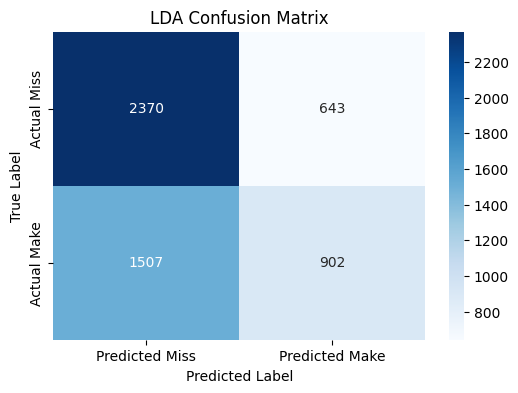

In [75]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\nTraining LDA model...")
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Predictions
y_pred_lda = lda.predict(X_test)
y_proba_lda = lda.predict_proba(X_test)[:, 1]

# Evaluation
print("\nLDA Classification Report:")
print(classification_report(y_test, y_pred_lda))
print(f"LDA ROC AUC: {roc_auc_score(y_test, y_proba_lda):.4f}")
print(f"LDA PR AUC: {average_precision_score(y_test, y_proba_lda):.4f}")

# Confusion Matrix
print("\nLDA Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_lda)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Miss', 'Predicted Make'],
            yticklabels=['Actual Miss', 'Actual Make'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('LDA Confusion Matrix')
plt.show()

</br>

##### Benchmark Model: Random Forest


Training Random Forest model...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.65      0.62      3013
           1       0.50      0.44      0.47      2409

    accuracy                           0.56      5422
   macro avg       0.55      0.55      0.54      5422
weighted avg       0.55      0.56      0.55      5422

RF ROC AUC: 0.5662
RF PR AUC: 0.5306

Random Forest Confusion Matrix:


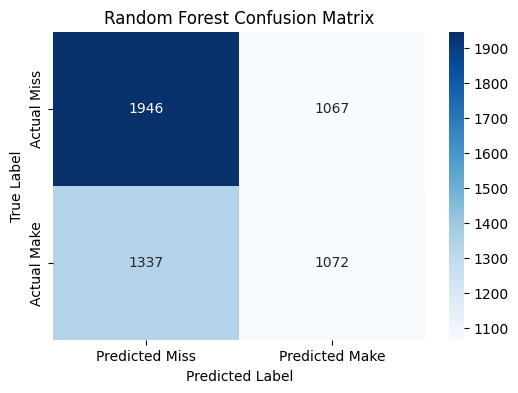


Top 10 Random Forest Feature Importances:
        feature  importance
   DEF_PRESSURE    0.248168
   SMART_2P_PCT    0.231080
      SHOT_DIST    0.165926
     SHOT_ANGLE    0.162194
   SMART_3P_PCT    0.157588
     LATE_CLOCK    0.011884
    CLUTCH_TIME    0.011184
RESTRICTED_AREA    0.009215
            3PT    0.002761


In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
import pandas as pd

print("\nTraining Random Forest model...")
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"RF ROC AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")
print(f"RF PR AUC: {average_precision_score(y_test, y_proba_rf):.4f}")

# Confusion Matrix
print("\nRandom Forest Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Miss', 'Predicted Make'],
            yticklabels=['Actual Miss', 'Actual Make'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Feature importance
importance_df = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 10 Random Forest Feature Importances:")
print(importance_df.head(10).to_string(index=False))

</br>

##### Benchmark Model: MLP (Multilayer Perceptron)

In [70]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


# Modell
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Training
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluation
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

Epoch 1/100
529/529 [==============================] - 2s 2ms/step - loss: 0.6736 - accuracy: 0.5843 - precision_1: 0.5672 - recall_1: 0.4277 - val_loss: 0.6570 - val_accuracy: 0.6175 - val_precision_1: 0.6481 - val_recall_1: 0.3911 - lr: 5.0000e-04
Epoch 2/100
529/529 [==============================] - 1s 2ms/step - loss: 0.6663 - accuracy: 0.5958 - precision_1: 0.6079 - recall_1: 0.3555 - val_loss: 0.6552 - val_accuracy: 0.6170 - val_precision_1: 0.6493 - val_recall_1: 0.3865 - lr: 5.0000e-04
Epoch 3/100
529/529 [==============================] - 1s 2ms/step - loss: 0.6656 - accuracy: 0.5959 - precision_1: 0.6122 - recall_1: 0.3450 - val_loss: 0.6587 - val_accuracy: 0.6139 - val_precision_1: 0.7023 - val_recall_1: 0.2971 - lr: 5.0000e-04
Epoch 4/100
529/529 [==============================] - 1s 2ms/step - loss: 0.6652 - accuracy: 0.5967 - precision_1: 0.6216 - recall_1: 0.3275 - val_loss: 0.6545 - val_accuracy: 0.6151 - val_precision_1: 0.6720 - val_recall_1: 0.3393 - lr: 5.0000e-04


In [74]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Wahrscheinlichkeiten berechnen
y_probs = model.predict(X_test).flatten()


thresholds = [i/100 for i in range(35, 66, 2)]

# Checking Evaluation-Metrics for different Thresholds:
for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    accuracy = accuracy_score(y_test, y_pred_thresh)
    print(f"Threshold: {thresh:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f} | Accuracy: {accuracy:.2f}")
# THRESHOLD ==> 0.44

170/170 [==============================] - 0s 862us/step
Threshold: 0.35 | Precision: 0.45 | Recall: 0.96 | F1: 0.62 | Accuracy: 0.47
Threshold: 0.37 | Precision: 0.46 | Recall: 0.93 | F1: 0.62 | Accuracy: 0.48
Threshold: 0.39 | Precision: 0.47 | Recall: 0.87 | F1: 0.61 | Accuracy: 0.51
Threshold: 0.41 | Precision: 0.48 | Recall: 0.76 | F1: 0.59 | Accuracy: 0.53
Threshold: 0.43 | Precision: 0.51 | Recall: 0.65 | F1: 0.57 | Accuracy: 0.57
Threshold: 0.45 | Precision: 0.54 | Recall: 0.52 | F1: 0.53 | Accuracy: 0.59
Threshold: 0.47 | Precision: 0.57 | Recall: 0.40 | F1: 0.47 | Accuracy: 0.60
Threshold: 0.49 | Precision: 0.60 | Recall: 0.34 | F1: 0.44 | Accuracy: 0.61
Threshold: 0.51 | Precision: 0.61 | Recall: 0.30 | F1: 0.40 | Accuracy: 0.60
Threshold: 0.53 | Precision: 0.63 | Recall: 0.25 | F1: 0.36 | Accuracy: 0.60
Threshold: 0.55 | Precision: 0.65 | Recall: 0.23 | F1: 0.34 | Accuracy: 0.60
Threshold: 0.57 | Precision: 0.67 | Recall: 0.21 | F1: 0.31 | Accuracy: 0.60
Threshold: 0.59 | P

</br>

# 6. Results
</br>

##### For Model-Analysis: Load and preprocess data + Load the Trace + Recreate Model Distributions

In [15]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- Load & preprocess ---
df = pd.read_csv('../data/shot_logs_modified.csv')
top_players = df['player_id'].value_counts().head(30).index
df = df[df['player_id'].isin(top_players)]
features = ['SHOT_DIST','CLOSE_DEF_DIST','DRIBBLES','TOUCH_TIME','PTS_TYPE',
            'SHOT_NUMBER','HOME_GAME','LATE_GAME','CLUTCH_TIME','TIME_PRESSURE']
target = 'FGM'

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target])
scale_cols = ['SHOT_DIST','CLOSE_DEF_DIST','DRIBBLES','TOUCH_TIME','SHOT_NUMBER']
scaler = StandardScaler()
train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])
test_df[scale_cols] = scaler.transform(test_df[scale_cols])

X_test = test_df[features].values
y_test = test_df[target].values
player_idx_test = test_df['player_id'].astype('category').cat.codes.values

# --- Load trace ---
trace = az.from_netcdf("nba_shooting_trace.nc")

# --- Model context for Model-Analysis ---
with pm.Model() as hierarchical_logistic_model:
    n_players, n_features = len(np.unique(player_idx_test)), X_test.shape[1]
    a_mu = pm.Normal('mu_a', 0, 1)
    sigma_a = pm.HalfNormal('sigma_a', 1)
    a_player = pm.Normal('a_player', a_mu, sigma_a, shape=n_players)
    b_mu = pm.Normal('mu_b', 0, 1, shape=n_features)
    sigma_b = pm.HalfNormal('sigma_b', 1, shape=n_features)
    b_player = pm.Normal('b_player', b_mu, sigma_b, shape=(n_players, n_features))
    logits = a_player[player_idx_test] + pm.math.sum(b_player[player_idx_test] * X_test, axis=1)
    y_pred = pm.Bernoulli('y_pred', logit_p=logits, observed=y_test)


### 6.1 BLAH

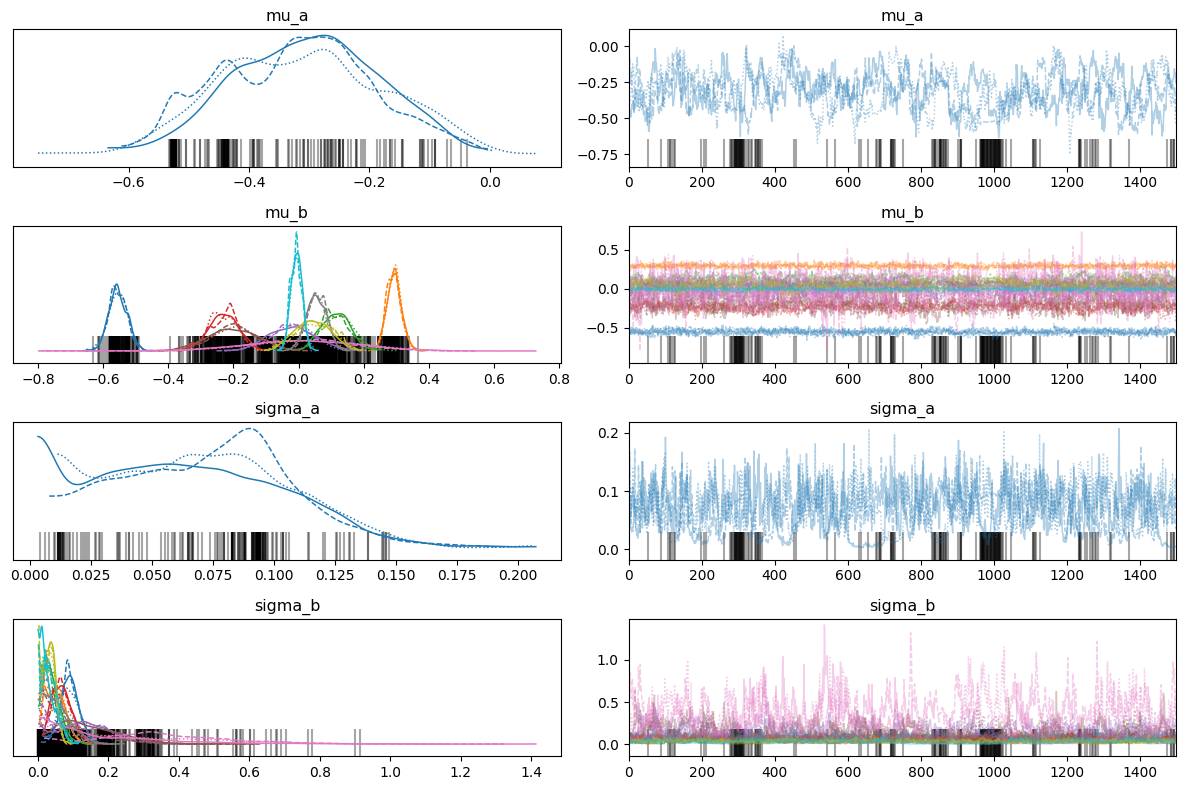

Sampling: [y_pred]


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_a       -0.313  0.127  -0.531   -0.071      0.010    0.007     157.0   
mu_b[0]    -0.555  0.028  -0.607   -0.501      0.001    0.001     633.0   
mu_b[1]     0.293  0.022   0.252    0.335      0.001    0.001     903.0   
mu_b[2]     0.116  0.047   0.030    0.201      0.003    0.003     186.0   
mu_b[3]    -0.232  0.046  -0.314   -0.141      0.003    0.002     190.0   
mu_b[4]    -0.018  0.069  -0.150    0.105      0.003    0.002     522.0   
mu_b[5]    -0.199  0.074  -0.339   -0.060      0.003    0.002     574.0   
mu_b[6]     0.013  0.168  -0.318    0.305      0.006    0.004     780.0   
mu_b[7]     0.056  0.030  -0.002    0.114      0.001    0.001    1146.0   
mu_b[8]     0.046  0.057  -0.061    0.144      0.005    0.003     158.0   
mu_b[9]    -0.006  0.017  -0.037    0.027      0.001    0.000     687.0   
sigma_a     0.069  0.036   0.004    0.127      0.003    0.002     161.0   
sigma_b[0]  0.089  0.030 

[0.26634086 0.63923808 0.53760613 ... 0.45553112 0.62733278 0.25843062]
Accuracy: 0.592
ROC AUC: 0.606
Confusion Matrix:
[[2264  607]
 [1561  879]]


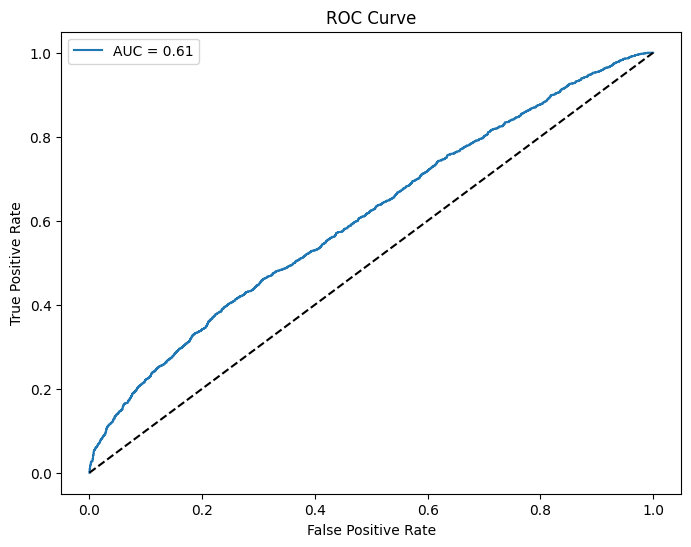

In [16]:
# Trace inspection
az.plot_trace(trace, var_names=['mu_a', 'mu_b', 'sigma_a', 'sigma_b'])
plt.tight_layout()
plt.show()
# Summary statistics
print(az.summary(trace, var_names=['mu_a', 'mu_b', 'sigma_a', 'sigma_b']))

# Posterior predictive checks
with hierarchical_logistic_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=['y_pred'])




# Calculate accuracy on test set
# 2. Manuelle Vorhersagefunktion
def predict_manual(trace, X_test, player_idx_test):
    # Parameter extrahieren
    a_player = trace.posterior['a_player'].mean(dim=('chain','draw')).values
    b_player = trace.posterior['b_player'].mean(dim=('chain','draw')).values
    
    # Logits berechnen
    logits = a_player[player_idx_test] + (b_player[player_idx_test] * X_test).sum(axis=1)
    
    # Wahrscheinlichkeiten berechnen
    return 1 / (1 + np.exp(-logits))

# 3. Vorhersagen generieren
test_probs = predict_manual(trace, X_test, player_idx_test)
test_preds = (test_probs > 0.5).astype(int)

# Sample predictions using all posterior samples
all_preds = []
for i in range(trace.posterior.dims['draw']):
    a = trace.posterior['a_player'].isel(draw=i).mean(dim='chain').values
    b = trace.posterior['b_player'].isel(draw=i).mean(dim='chain').values
    logits = a[player_idx_test] + (b[player_idx_test] * X_test).sum(axis=1)
    prob = 1 / (1 + np.exp(-logits))
    all_preds.append(prob)
all_preds = np.stack(all_preds)
mean_probs = all_preds.mean(axis=0)
print(mean_probs)
#print(mean_probs.shape())

# 4. Evaluation
print(f"Accuracy: {accuracy_score(y_test, test_preds):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, test_probs):.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_preds))

# 5. ROC-Kurve
fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, test_probs):.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#### Overview of Players and their respective ID

In [17]:
# Get shot counts for each player_id
player_shot_counts = df['player_id'].value_counts().head(30)

# Get the top 30 player IDs sorted by shot attempts (highest first)
top_30_ids = player_shot_counts.index

# Get player info for these IDs and keep the same order
top_30_players = (df[df['player_id'].isin(top_30_ids)]
                 [['player_id', 'player_name']]
                 .drop_duplicates()
                 .set_index('player_id')
                 .loc[top_30_ids]  # This maintains the shot count order
                 .reset_index())

print("Top 30 Players (by shot attempts - highest first):")
print("------------------------------------------------")
for i, (_, row) in enumerate(top_30_players.iterrows(), 1):
    print(f"{i}. {row['player_name']}   \t\t(ID: {row['player_id']}) \t\t {player_shot_counts[row['player_id']]} shots")  # Fixed bracket

# Save to CSV
top_30_players['shot_attempts'] = top_30_players['player_id'].map(player_shot_counts)
top_30_players.to_csv('top_30_players_sorted.csv', index=False)

Top 30 Players (by shot attempts - highest first):
------------------------------------------------
1. james harden   		(ID: 201935) 		 1054 shots
2. mnta ellis   		(ID: 101145) 		 1052 shots
3. lamarcus aldridge   		(ID: 200746) 		 1050 shots
4. damian lillard   		(ID: 203081) 		 986 shots
5. lebron james   		(ID: 2544) 		 978 shots
6. klay thompson   		(ID: 202691) 		 971 shots
7. russell westbrook   		(ID: 201566) 		 969 shots
8. stephen curry   		(ID: 201939) 		 968 shots
9. kyrie irving   		(ID: 202681) 		 942 shots
10. tyreke evans   		(ID: 201936) 		 914 shots
11. nikola vucevic   		(ID: 202696) 		 902 shots
12. blake griffin   		(ID: 201933) 		 893 shots
13. chris paul   		(ID: 101108) 		 885 shots
14. kyle lowry   		(ID: 200768) 		 879 shots
15. rudy gay   		(ID: 200752) 		 879 shots
16. john wall   		(ID: 202322) 		 874 shots
17. gordon hayward   		(ID: 202330) 		 867 shots
18. anthony davis   		(ID: 203076) 		 841 shots
19. markieff morris   		(ID: 202693) 		 830 shots
20. b

In [18]:
# Get player-specific intercepts and coefficients
a_player_post = trace.posterior['a_player'].mean(dim=('chain', 'draw')).values
b_player_post = trace.posterior['b_player'].mean(dim=('chain', 'draw')).values

# Create dataframe with player effects
player_effects = pd.DataFrame({
    'player_id': player_ids,
    'baseline_logit': a_player_post
})

# Add coefficients for each feature
for i, feature in enumerate(features):
    player_effects[f'coef_{feature}'] = b_player_post[:, i]

# Merge with player names
player_names = df_top30[['player_id', 'player_name']].drop_duplicates()
player_effects = player_effects.merge(player_names, on='player_id')

# Calculate player-specific shooting probabilities under different conditions
def calculate_player_probability(player_id, feature_values):
    player_idx = np.where(player_ids == player_id)[0][0]
    logit = a_player_post[player_idx]
    for i, value in enumerate(feature_values):
        logit += b_player_post[player_idx, i] * value
    return np.exp(logit) / (1 + np.exp(logit))

# Example: Compare two players in clutch vs non-clutch
player1_id = df_top30['player_id'].iloc[0]  # Replace with actual player ID
player2_id = df_top30['player_id'].iloc[1]  # Replace with actual player ID

# Standardized feature values for non-clutch (median values)
non_clutch_features = train_df[features].median().values
non_clutch_features[features.index('CLUTCH_TIME')] = 0

# Standardized feature values for clutch
clutch_features = non_clutch_features.copy()
clutch_features[features.index('CLUTCH_TIME')] = 1

# Calculate probabilities
p1_non_clutch = calculate_player_probability(player1_id, non_clutch_features)
p1_clutch = calculate_player_probability(player1_id, clutch_features)
p2_non_clutch = calculate_player_probability(player2_id, non_clutch_features)
p2_clutch = calculate_player_probability(player2_id, clutch_features)

print(f"\nPlayer 1 ({player_effects.loc[player_effects['player_id'] == player1_id, 'player_name'].values[0]}):")
print(f"Non-clutch FG%: {p1_non_clutch:.2%}")
print(f"Clutch FG%: {p1_clutch:.2%}")
print(f"Difference: {(p1_clutch - p1_non_clutch):.2%}")

print(f"\nPlayer 2 ({player_effects.loc[player_effects['player_id'] == player2_id, 'player_name'].values[0]}):")
print(f"Non-clutch FG%: {p2_non_clutch:.2%}")
print(f"Clutch FG%: {p2_clutch:.2%}")
print(f"Difference: {(p2_clutch - p2_non_clutch):.2%}")


Player 1 (al jefferson):
Non-clutch FG%: 41.38%
Clutch FG%: 42.79%
Difference: 1.41%

Player 2 (al jefferson):
Non-clutch FG%: 41.38%
Clutch FG%: 42.79%
Difference: 1.41%


## 6.2 Overall distribution of coefficients (global and player-specific)

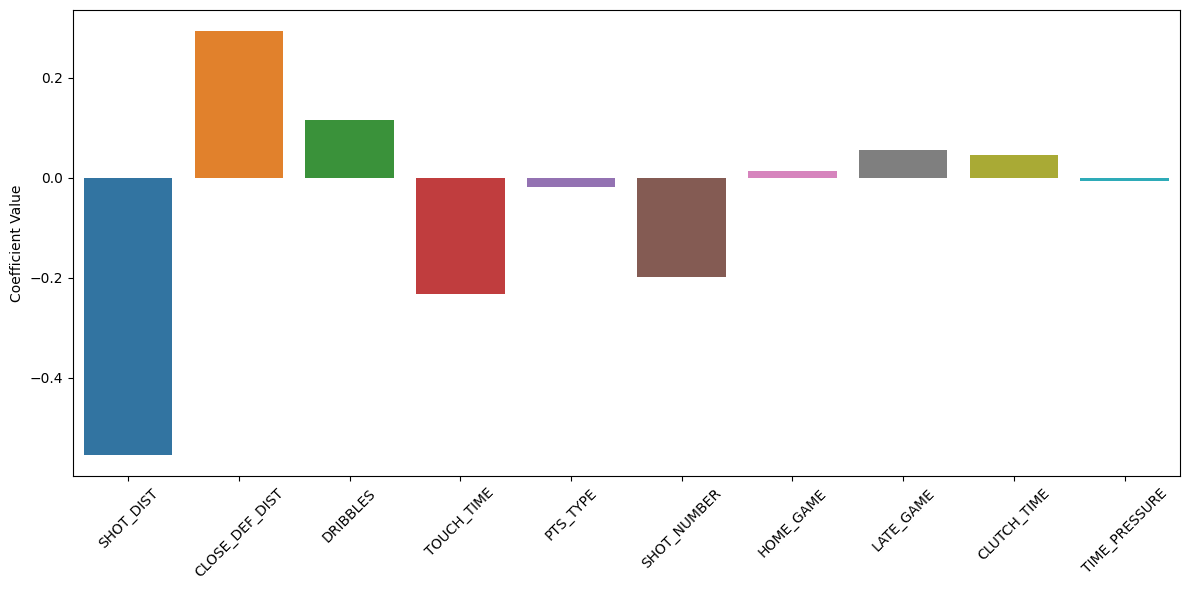

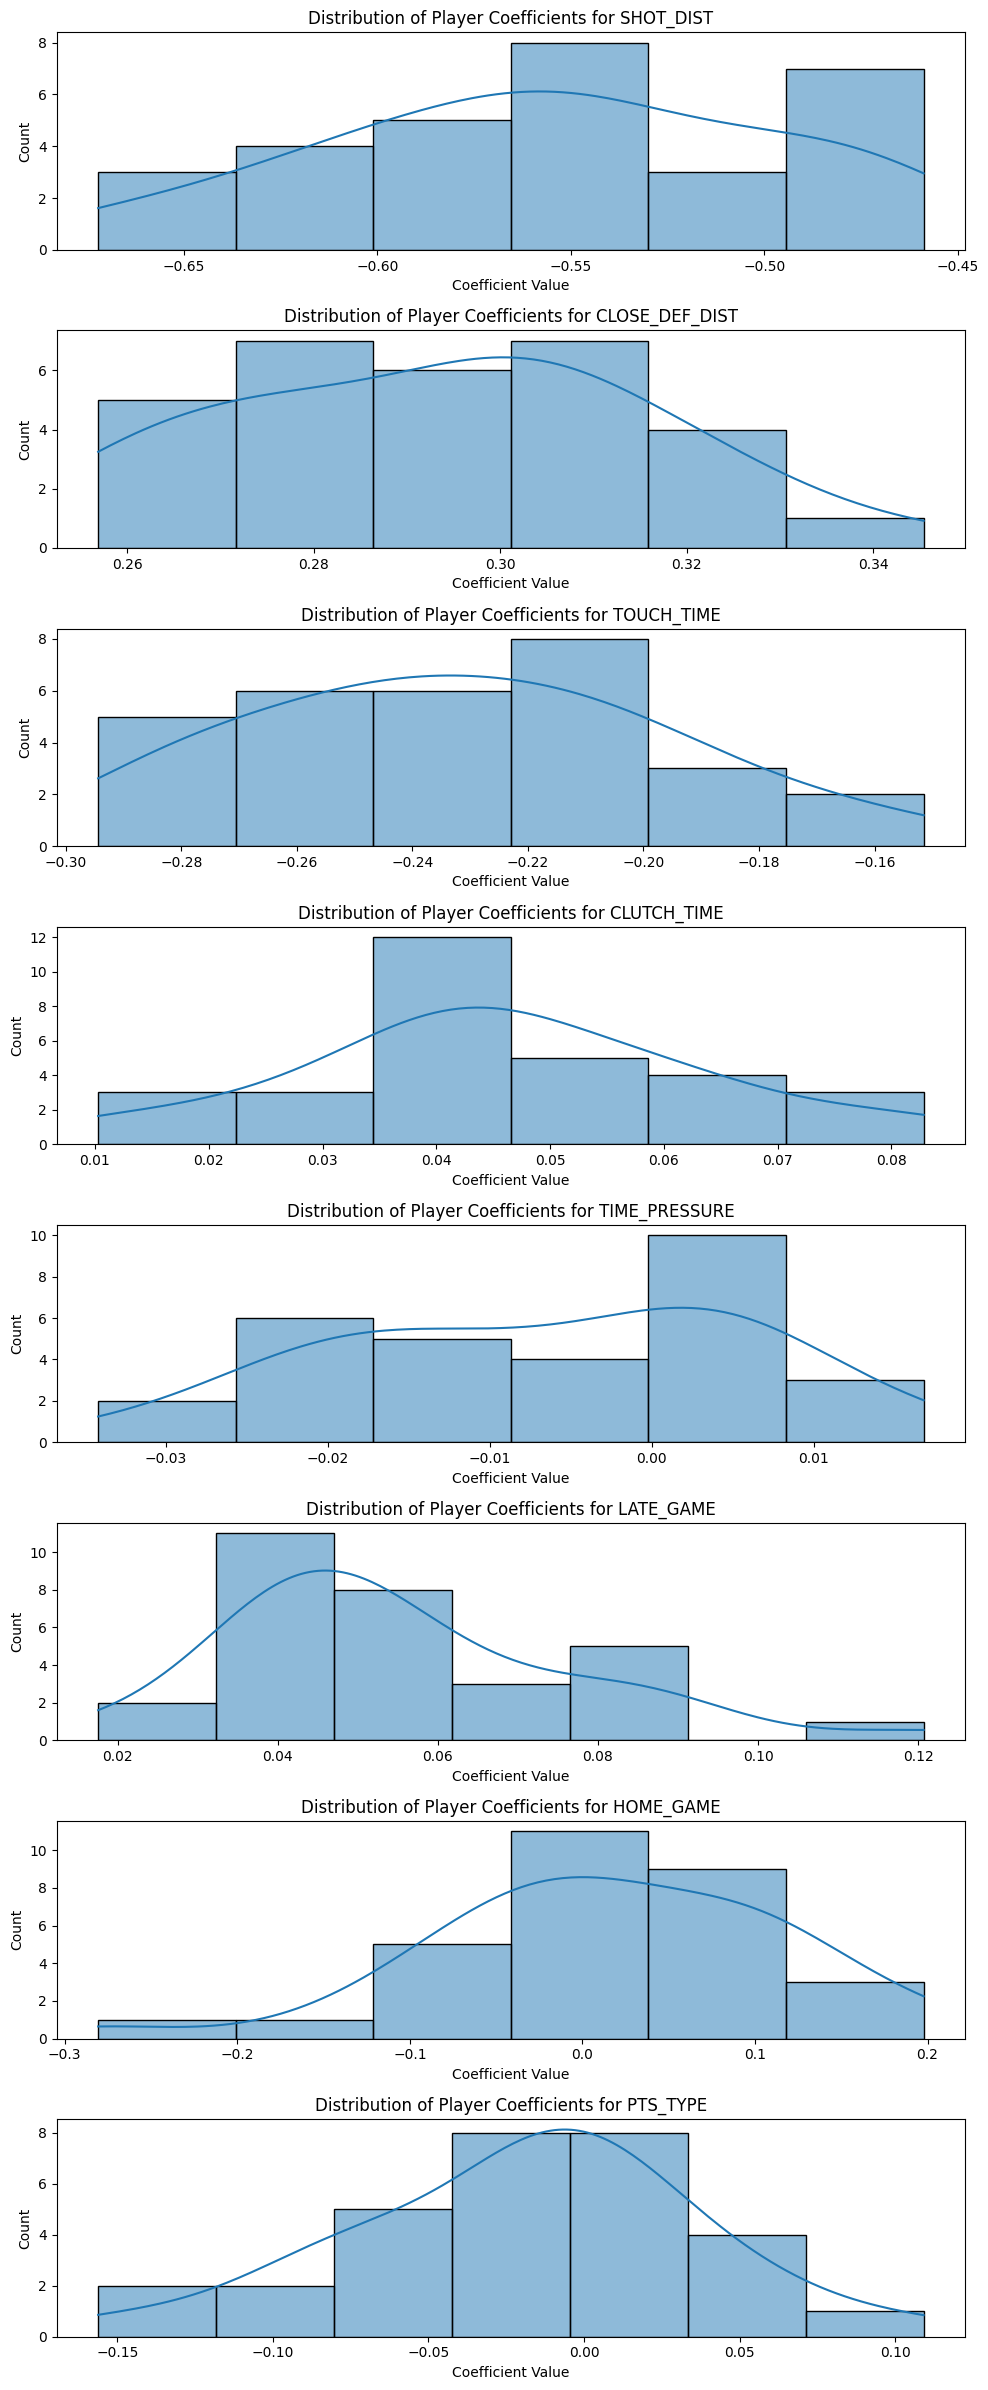

In [36]:
# Calculate global feature importance
global_coefs = trace.posterior['mu_b'].mean(dim=('chain', 'draw')).values

plt.figure(figsize=(12, 6))
sns.barplot(x=features, y=global_coefs)
plt.xticks(rotation=45)
#plt.title('Global Feature Importance (Average Coefficient Values)')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

# Plot player-specific coefficients for selected features
selected_features = ['SHOT_DIST', 'CLOSE_DEF_DIST', 'TOUCH_TIME', 'CLUTCH_TIME', 'TIME_PRESSURE', 'LATE_GAME', 'HOME_GAME', 'PTS_TYPE']
n_features = len(selected_features)

fig, axes = plt.subplots(n_features, 1, figsize=(10, 3*n_features))
for i, feature in enumerate(selected_features):
    feature_idx = features.index(feature)
    coefs = b_player_post[:, feature_idx]
    sns.histplot(coefs, ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of Player Coefficients for {feature}')
    axes[i].set_xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

## 6.3 Comparison of global (average) coefficients and a specific player's coefficients

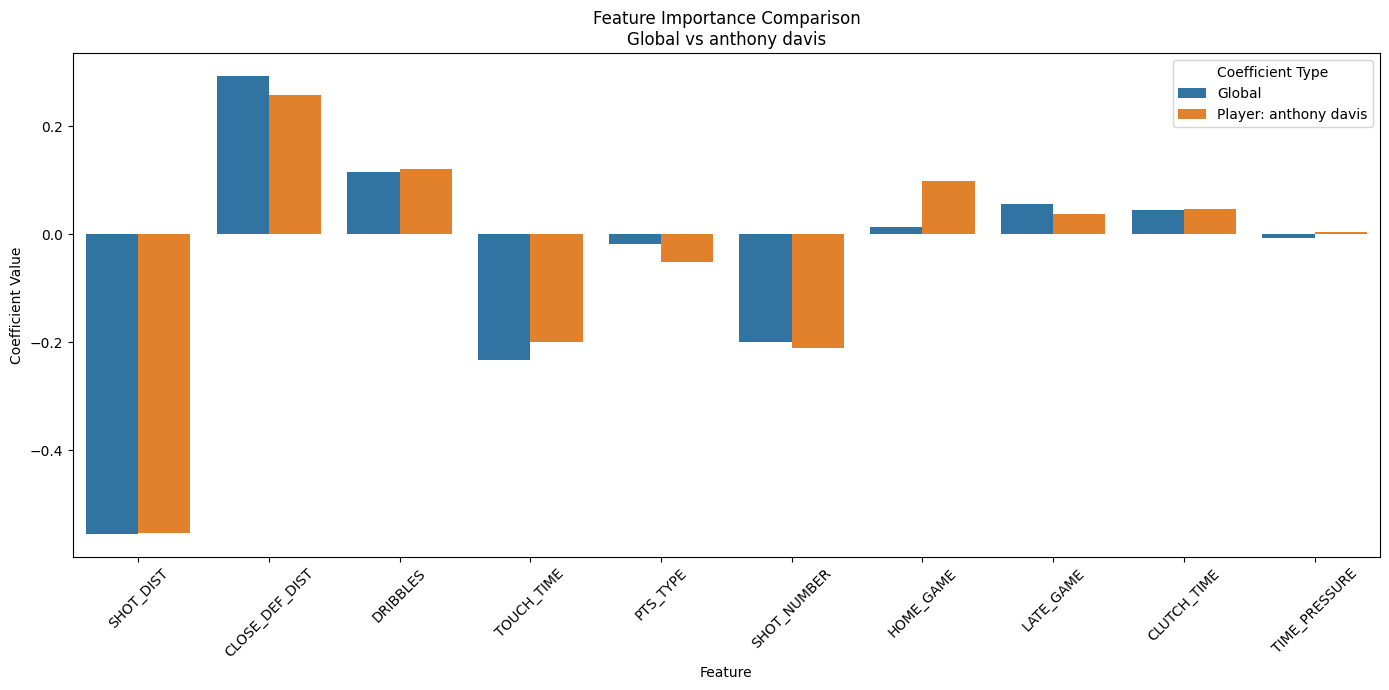

In [42]:
# Choose a player to compare (replace with actual player ID)
player_id_to_compare = 203076
player_name = df[df['player_id'] == player_id_to_compare]['player_name'].iloc[0]

# Get global and player-specific coefficients
global_coefs = trace.posterior['mu_b'].mean(dim=('chain', 'draw')).values


# Get all player coefficients (n_players × n_features)
players_coefs = trace.posterior['b_player'].mean(dim=('chain', 'draw'))

# Convert player_ids to match the model's indexing
player_id_map = {id: idx for idx, id in enumerate(player_ids)}
player_idx = player_id_map.get(player_id_to_compare)
if player_idx is None:
    raise ValueError(f"Player ID {player_id_to_compare} not found in model")
player_coefs = players_coefs[player_idx].values

# Prepare data for plotting
data = pd.DataFrame({
    'Feature': features * 2,  # Duplicate features for global and player
    'Coefficient': np.concatenate([global_coefs, player_coefs]),
    'Type': ['Global']*len(features) + [f'Player: {player_name}']*len(features)
})

# Create plot
plt.figure(figsize=(14, 7))
sns.barplot(
    x='Feature', 
    y='Coefficient', 
    hue='Type',
    data=data,
    palette=['#1f77b4', '#ff7f0e']  # Blue for global, orange for player
)

plt.xticks(rotation=45)
plt.title(f'Feature Importance Comparison\nGlobal vs {player_name}')
plt.ylabel('Coefficient Value')
plt.legend(title='Coefficient Type')
plt.tight_layout()
plt.show()

## 6.4 Manuell Comparison Of Player-Coefficients Between Two Players

Comparison of the players Damian Lillard and Marc Gasol (or alternatively Stephen Curry)


Feature                   damian lillard  marc gasol      Difference     
----------------------------------------------------------------------
SHOT_DIST                 -0.4690         -0.5357         0.0667         
CLOSE_DEF_DIST            0.2762          0.2805          -0.0043        
DRIBBLES                  0.0979          0.1249          -0.0270        
TOUCH_TIME                -0.2538         -0.2219         -0.0320        
PTS_TYPE                  -0.0877         0.0092          -0.0969        
SHOT_NUMBER               -0.1954         -0.1970         0.0016         
HOME_GAME                 0.0226          0.1155          -0.0929        
LATE_GAME                 0.0464          0.0810          -0.0345        
CLUTCH_TIME               0.0202          0.0827          -0.0625        
TIME_PRESSURE             -0.0155         -0.0208         0.0053         


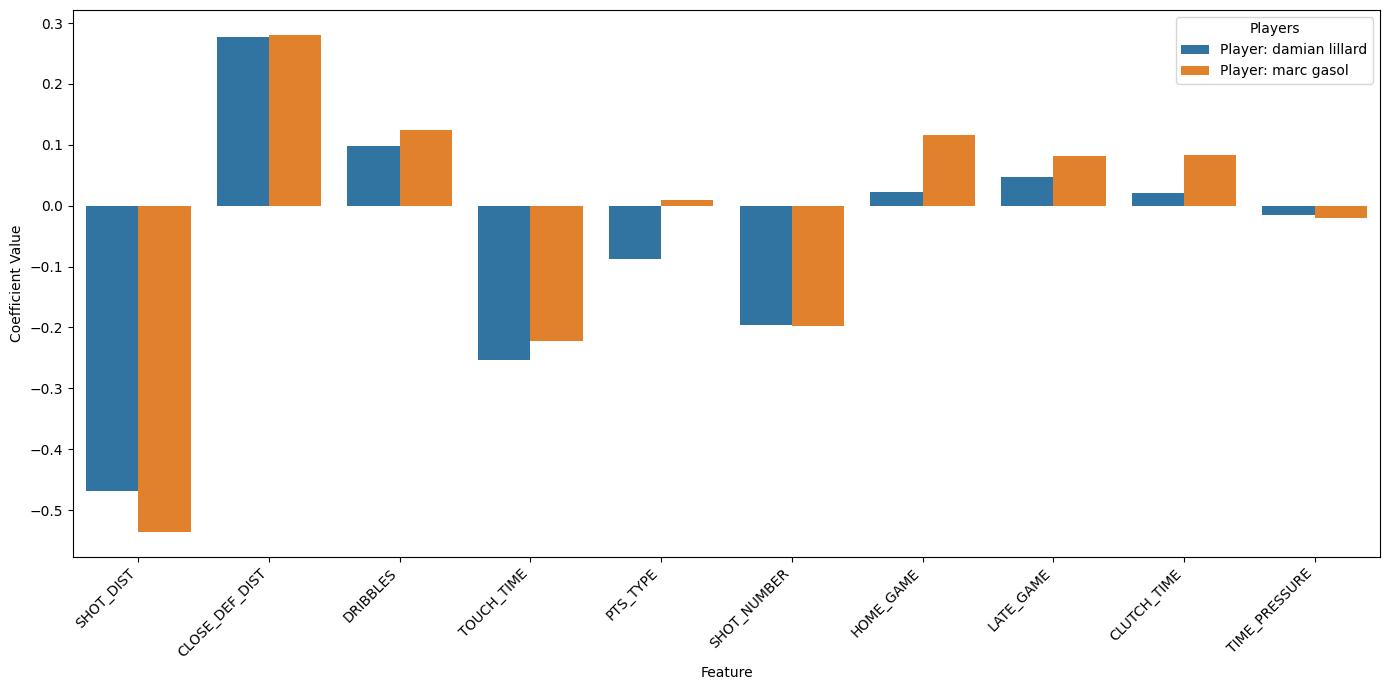

In [38]:
# Choose two players to compare (replace with actual player IDs)
player1_id = 203081  # Example: Damian Lillard
player2_id = 201188  # Example: Marc Gasol | 201939  #Stehpen Curry

# Get player names
player1_name = df[df['player_id'] == player1_id]['player_name'].iloc[0]
player2_name = df[df['player_id'] == player2_id]['player_name'].iloc[0]

# Get all player coefficients (n_players × n_features)
players_coefs = trace.posterior['b_player'].mean(dim=('chain', 'draw'))

# Convert player_ids to match the model's indexing
player_id_map = {id: idx for idx, id in enumerate(player_ids)}
player1_idx = player_id_map.get(player1_id)
player2_idx = player_id_map.get(player2_id)

if player1_idx is None:
    raise ValueError(f"Player ID {player1_id} not found in model")
if player2_idx is None:
    raise ValueError(f"Player ID {player2_id} not found in model")

player1_coefs = players_coefs[player1_idx].values
player2_coefs = players_coefs[player2_idx].values

# Create comparison DataFrame
coef_comparison = pd.DataFrame({
    'Feature': features,
    player1_name: player1_coefs,
    player2_name: player2_coefs,
    'Difference': player1_coefs - player2_coefs
})

# Print formatted coefficient comparison
print(f"\n{'Feature':<25} {player1_name:<15} {player2_name:<15} {'Difference':<15}")
print("-" * 70)
for _, row in coef_comparison.iterrows():
    print(f"{row['Feature']:<25} {row[player1_name]:<15.4f} {row[player2_name]:<15.4f} {row['Difference']:<15.4f}")

# Prepare data for plotting
data = pd.DataFrame({
    'Feature': features * 2,  # Duplicate features for both players
    'Coefficient': np.concatenate([player1_coefs, player2_coefs]),
    'Type': [f'Player: {player1_name}']*len(features) + [f'Player: {player2_name}']*len(features)
})

# Create plot
plt.figure(figsize=(14, 7))
sns.barplot(
    x='Feature', 
    y='Coefficient', 
    hue='Type',
    data=data,
    palette=['#1f77b4', '#ff7f0e']  # Different colors for each player
)

plt.xticks(rotation=45, ha='right')
#plt.title(f'Player-Specific Feature Coefficients Comparison\n{player1_name} vs {player2_name}')
plt.ylabel('Coefficient Value')
plt.legend(title='Players')
plt.tight_layout()
plt.show()

##### General Statistics For 3-Point Shots For Players Stephen Curry And Marc Gasol As Well As The Across-League Average:

In [34]:
# Identify Stephen Curry's player ID
curry_id = 201939  # Stephen Curry's player ID

# Create separate dataframes
df_curry = df[df['player_id'] == curry_id].copy()
df_others = df[df['player_id'] != curry_id].copy()

# Function to calculate 3-point stats
def calculate_3pt_stats(df, player_name):
    # Calculate games played and 3-point stats
    stats = df.groupby('player_id').agg(
        games_played=('GAME_ID', 'nunique'),
        three_pt_makes=('FGM', lambda x: x[df.loc[x.index, 'PTS_TYPE'] == 3].sum()),
        three_pt_attempts=('FGM', lambda x: (df.loc[x.index, 'PTS_TYPE'] == 3).sum()),
        avg_shot_distance=('SHOT_DIST', lambda x: x[df.loc[x.index, 'PTS_TYPE'] == 3].mean())
    )
    
    # Calculate averages
    stats['3PA_per_game'] = stats['three_pt_attempts'] / stats['games_played']
    stats['3P_percentage'] = stats['three_pt_makes'] / stats['three_pt_attempts']
    
    # Get mean values (for other players)
    if player_name == "Other Players":
        stats = stats.mean().to_frame().T
        stats['player_name'] = player_name
    else:
        stats['player_name'] = player_name
    
    return stats[['player_name', '3PA_per_game', '3P_percentage', 'avg_shot_distance']]

# Calculate stats for Curry and other players
curry_stats = calculate_3pt_stats(df_curry, "Stephen Curry")
others_stats = calculate_3pt_stats(df_others, "Other Players")

# Combine results
combined_stats = pd.concat([curry_stats, others_stats], ignore_index=True)

# Format output
combined_stats['3P_percentage'] = combined_stats['3P_percentage'].apply(lambda x: f"{x:.1%}")
combined_stats['avg_shot_distance'] = combined_stats['avg_shot_distance'].apply(lambda x: f"{x:.1f} feet")
combined_stats['3PA_per_game'] = combined_stats['3PA_per_game'].apply(lambda x: f"{x:.1f}")

# Display results
print("3-Point Shooting Statistics Comparison:")
print(combined_stats.to_string(index=False))

3-Point Shooting Statistics Comparison:
  player_name 3PA_per_game 3P_percentage avg_shot_distance
Stephen Curry          7.9         41.7%         25.3 feet
Other Players          3.3         36.8%         24.8 feet


In [35]:
import pandas as pd

# Filter for the three specific players
players_of_interest = {
    201939: "Stephen Curry",
    201188: "Marc Gasol"
}

# Create filtered dataframe
df_filtered = df[df['player_id'].isin(players_of_interest.keys())].copy()

# Calculate games played and 3-point stats
player_stats = df_filtered.groupby(['player_id', 'player_name']).agg(
    games_played=('GAME_ID', 'nunique'),  # Count unique games
    three_pt_makes=('FGM', lambda x: x[df_filtered.loc[x.index, 'PTS_TYPE'] == 3].sum()),
    three_pt_attempts=('FGM', lambda x: (df_filtered.loc[x.index, 'PTS_TYPE'] == 3).sum()),
    avg_shot_distance=('SHOT_DIST', lambda x: x[df_filtered.loc[x.index, 'PTS_TYPE'] == 3].mean())
).reset_index()

# Calculate averages
player_stats['3PA_per_game'] = player_stats['three_pt_attempts'] / player_stats['games_played']
player_stats['3P_percentage'] = player_stats['three_pt_makes'] / player_stats['three_pt_attempts']

# Format output
player_stats['3P_percentage'] = player_stats['3P_percentage'].apply(lambda x: f"{x:.1%}")
player_stats['avg_shot_distance'] = player_stats['avg_shot_distance'].apply(lambda x: f"{x:.1f} feet")
player_stats['3PA_per_game'] = player_stats['3PA_per_game'].apply(lambda x: f"{x:.1f}")

# Select and sort columns
final_stats = player_stats[['player_name', '3PA_per_game', '3P_percentage', 'avg_shot_distance']]
final_stats = final_stats.sort_values('3PA_per_game', ascending=False)

# Display results
print("Average 3-Point Shooting Statistics Per Game:")
print(final_stats.to_string(index=False))

Average 3-Point Shooting Statistics Per Game:
  player_name 3PA_per_game 3P_percentage avg_shot_distance
stephen curry          7.9         41.7%         25.3 feet
   marc gasol          0.2         14.3%         24.4 feet


## 6.5 Comparison Of Player-Coefficients Of Player With Maximum Coefficient In Particular Predictor-Variable With Player-Coefficients Of Player With Minimum Coefficient For Respective Predictor-Variable 

... hier die variables die wo max und min verglichen werden: ...

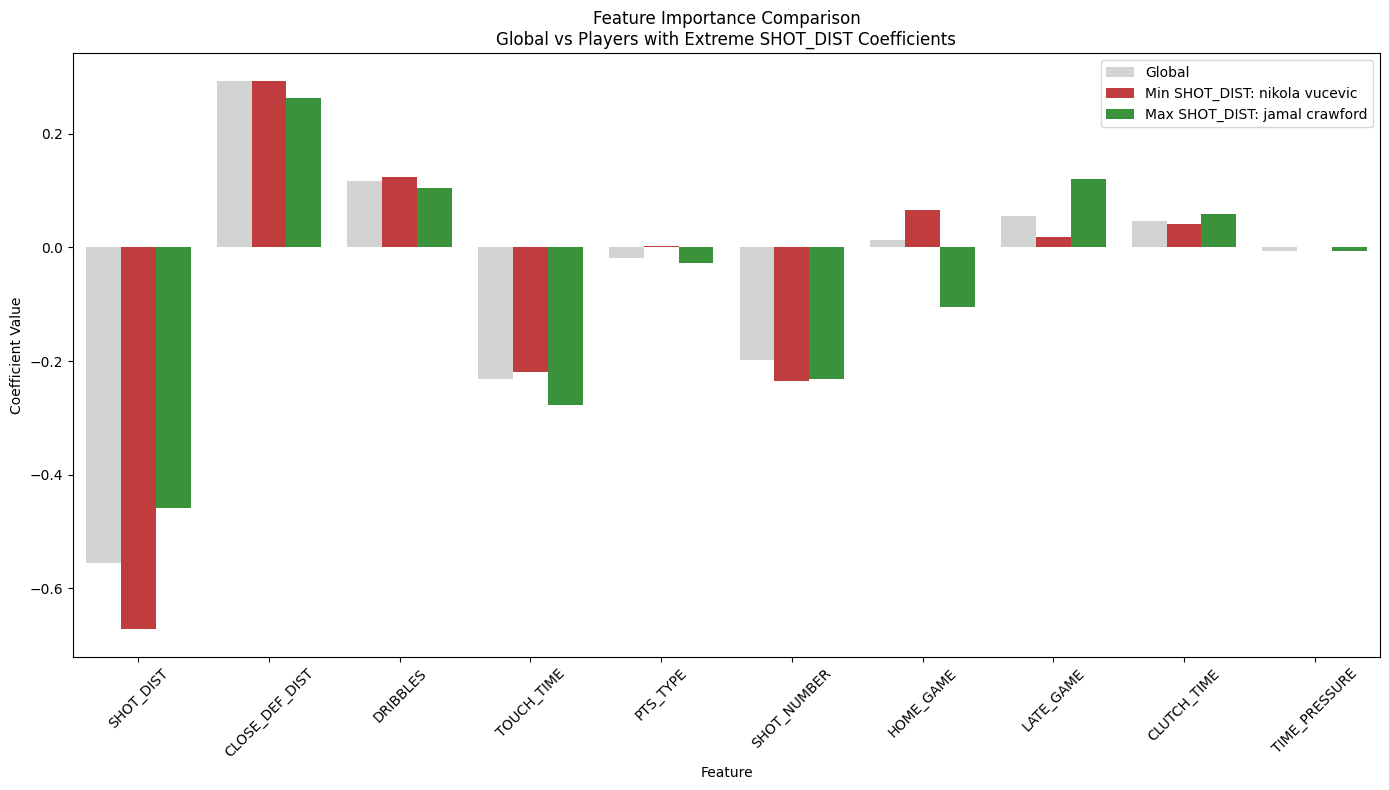


Players with extreme coefficients for 'SHOT_DIST':
- MAX: jamal crawford (coef = -0.459)
- MIN: nikola vucevic (coef = -0.672)


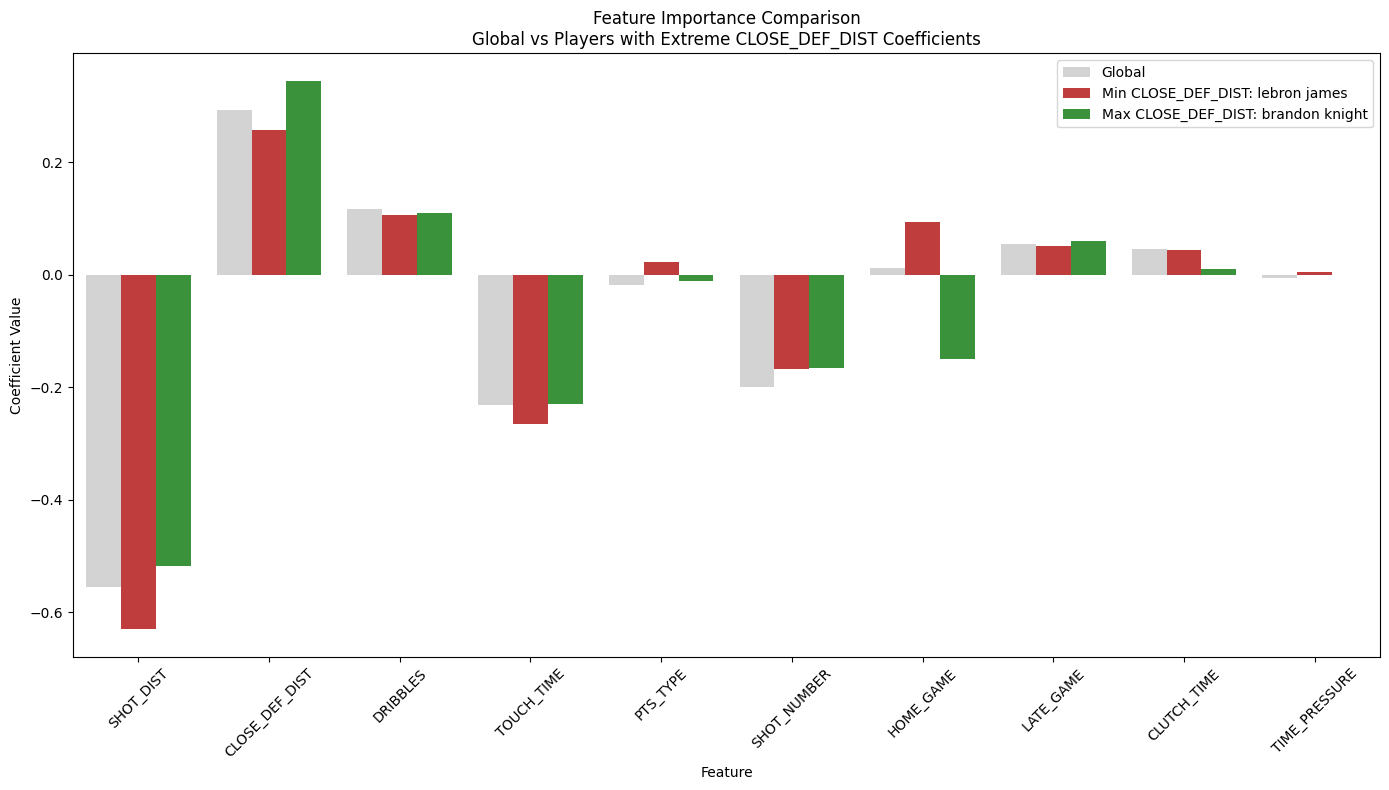


Players with extreme coefficients for 'CLOSE_DEF_DIST':
- MAX: brandon knight (coef = 0.345)
- MIN: lebron james (coef = 0.257)


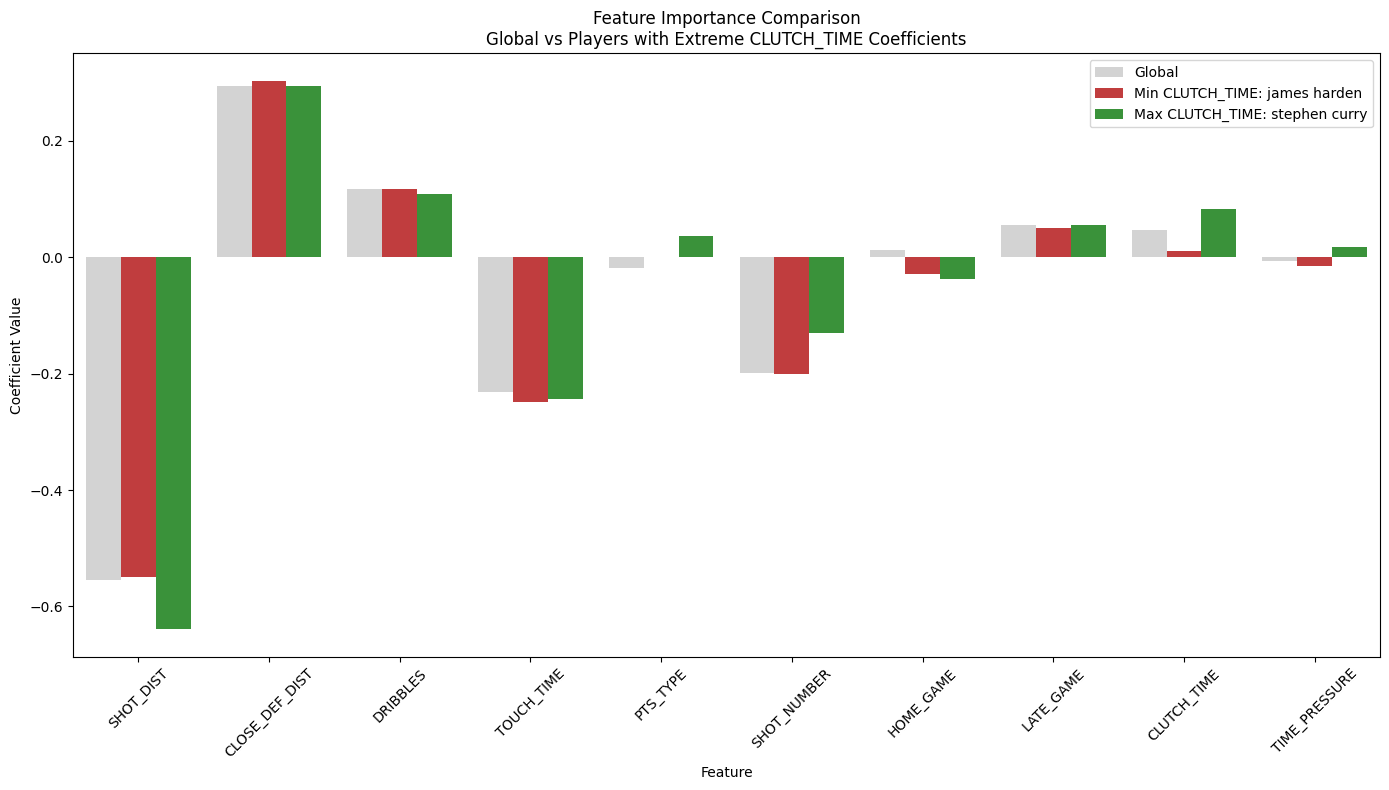


Players with extreme coefficients for 'CLUTCH_TIME':
- MAX: stephen curry (coef = 0.083)
- MIN: james harden (coef = 0.010)


In [24]:
def plot_feature_extremes(feature_name):
    # Get index of the requested feature
    try:
        feature_idx = features.index(feature_name)
    except ValueError:
        raise ValueError(f"Feature '{feature_name}' not found. Available features: {features}")

    # Get all player coefficients (n_players × n_features)
    players_coefs = trace.posterior['b_player'].mean(dim=('chain', 'draw')).values
    
    # Find players with min and max coefficients for this feature
    feature_coefs = players_coefs[:, feature_idx]
    min_player_idx = np.argmin(feature_coefs)
    max_player_idx = np.argmax(feature_coefs)
    
    # Get their IDs and names
    min_player_id = player_ids[min_player_idx]
    max_player_id = player_ids[max_player_idx]
    min_player_name = df[df['player_id'] == min_player_id]['player_name'].iloc[0]
    max_player_name = df[df['player_id'] == max_player_id]['player_name'].iloc[0]
    
    # Prepare data for plotting
    plot_data = []
    
    # Add global coefficients
    global_coefs = trace.posterior['mu_b'].mean(dim=('chain', 'draw')).values
    for i, feat in enumerate(features):
        plot_data.append({
            'Feature': feat,
            'Coefficient': global_coefs[i],
            'Type': 'Global'
        })
    
    # Add min player coefficients
    for i, feat in enumerate(features):
        plot_data.append({
            'Feature': feat,
            'Coefficient': players_coefs[min_player_idx][i],
            'Type': f'Min {feature_name}: {min_player_name}'
        })
    
    # Add max player coefficients
    for i, feat in enumerate(features):
        plot_data.append({
            'Feature': feat,
            'Coefficient': players_coefs[max_player_idx][i],
            'Type': f'Max {feature_name}: {max_player_name}'
        })
    
    # Create DataFrame
    plot_df = pd.DataFrame(plot_data)
    
    # Create plot
    plt.figure(figsize=(14, 8))
    sns.barplot(
        x='Feature', 
        y='Coefficient', 
        hue='Type',
        data=plot_df,
        palette=['lightgrey', '#d62728', '#2ca02c']  # Blue, Red, Green
    )
    
    plt.xticks(rotation=45)
    plt.title(f'Feature Importance Comparison\nGlobal vs Players with Extreme {feature_name} Coefficients')
    plt.ylabel('Coefficient Value')
    plt.legend(title='')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nPlayers with extreme coefficients for '{feature_name}':")
    print(f"- MAX: {max_player_name} (coef = {feature_coefs[max_player_idx]:.3f})")
    print(f"- MIN: {min_player_name} (coef = {feature_coefs[min_player_idx]:.3f})")

# Example usage:
plot_feature_extremes('SHOT_DIST')
plot_feature_extremes('CLOSE_DEF_DIST')
plot_feature_extremes('CLUTCH_TIME')

## 7. Discussion

</br>

**All of this can also be read in the Report**

</br>

#### Interpretation of Benchmark Results

The results of the benchmark models provide important insights into the predictive power of the current feature set and highlight the challenges faced by the existing Bayesian hierarchical logistic regression model. The linear model (LDA) achieved an accuracy of 60%, nearly identical to the primary model, indicating that the shot outcome classes are not easily separable by linear means. Similarly, the Random Forest model, despite its non-linear structure, only reached a marginally lower accuracy of 56%. This suggests that the complex relationships between features and shot outcomes might not be fully captured by the available data, as even non-linear models failed to significantly outperform the simpler approaches. The Neural Network, with its added representational capacity, achieved an accuracy of 61%, but its precision and recall values indicated limited improvements in predictive power, further reinforcing the notion that the feature set does not adequately capture the nuances of shot success.
</br>

These findings underscore a critical point: while the advanced feature engineering process introduced new, context-aware variables, such as SMART_2P_PCT, SMART_3P_PCT, and SHOT_ANGLE, they did not contribute substantially to improving model performance. This suggests that, despite their theoretical relevance, these features do not possess the level of explanatory power needed for robust shot outcome prediction. Consequently, the dominant influence of traditional shot-related statistics, such as SHOT_DIST and DEF_PRESSURE, remains a key factor in the predictive accuracy. Therefore, future modeling efforts may need to revisit feature engineering or explore alternative approaches, including more sophisticated machine learning techniques or a different feature set altogether, to improve prediction performance.
</br>

##### Main Takeaway:
The results from the benchmark models suggest that the performance of the Bayesian hierarchical logistic regression model, with an accuracy of 59.2\%, is close to the maximum achievable with the available data. Despite extensive feature engineering and the use of other linear models like LDA or more advanced models such as Random Forest and Neural Networks, all models reached a similar performance, with accuracies around 60\%. The precision and recall metrics remained similarly modest across all models, with no significant improvement despite the increased complexity.
\\
This indicates that the feature set, even after incorporating more complex and context-aware variables, is insufficient to improve predictive performance beyond a certain threshold. There might be factors influencing shot outcomes that are not captured in the available features. As a result, improving model performance beyond this point appears unattainable with the current data. 
\\
Therefore, the key takeaway is that the performance ceiling for this problem is likely capped due to an inherent randomness in NBA shooting that leads to an intrinsic unpredictability of shot success regardless of model complexity.

### Analysis of the Hierarchical Logistic Regression Model

#### Global and Player-Specific Effects of Contextual Variables
The Bayesian hierarchical logistic regression model estimates both global (population-level) effects
and player-specific deviations. Figure at Notebook 6.3 shows global average coefficients: Among all predictors, shot
distance (SHOT DIST) exhibits the largest magnitude, with a substantial negative coefficient, confirming the intuitive relationship that longer shots have a lower probability of success. Defender
proximity (CLOSE DEF DIST) shows the second-strongest effect, positively associated with shot success—indicating that increased space from the nearest defender improves shooting outcomes. Smaller
but still significant effects are observed for dribbles and touch time (TOUCH TIME) as well as
shot sequence position (SHOT NUMBER), with the latter displaying a significant negative association. This suggests a possible influence of fatigue, as higher shot numbers generally occur later in
games, when physical exertion may degrade shooting performance. Variables such as HOME GAME,
CLUTCH TIME, and TIME PRESSURE show minimal global influence, indicating substantial interplayer variability. The limited impact of clutch time at the population level is likely due to its rarity,
as such situations occur only in closely contested games during the final minutes, reducing their overall
statistical weight in determining shot success.
Figure 8 highlights this variability. While the SHOT DIST effect is consistently negative, some players are less affected, likely due to long-range shooting skill. Similarly, CLOSE DEF DIST benefits
most players, but the magnitude varies. Pressure-related variables (LATE GAME, CLUTCH TIME,
TIME PRESSURE) and HOME GAME effects are centered near zero with wide distributions, indicating that some players thrive under these conditions while others decline.
These findings support the hypothesis that while certain contextual factors (distance, defensive pressure) have strong universal effects, many situational influences are player-specific. The heterogeneity
in coefficients underscores the importance of individualized performance modeling and suggests that a
significant portion of shot outcome variability is inherently stochastic, limiting predictive accuracy.

#### Player-Specific Coefficients: Damian Lillard vs. Marc Gasol
To illustrate the interpretive value of the hierarchical structure, Figure at Notebook section 6.4 compares player-specific coefficients for Damian Lillard and Marc Gasol—two players with contrasting profiles during the 2014–15
season. Lillard, an elite perimeter shooter and guard, shows a less negative effect for SHOT DIST than
Gasol, indicating greater efficiency from longer range. Both players benefit similarly from increased
CLOSE DEF DIST, though Lillard’s advantage is slightly smaller, suggesting that defensive pressure
impacts them in comparable ways despite stylistic differences.
Lillard exhibits a more positive response to DRIBBLES, consistent with his role as a ball-dominant
shot creator, while Gasol shows a stronger positive effect for HOME GAME and LATE GAME, possibly reflecting performance boosts in familiar environments or under certain game contexts. For
TOUCH TIME, both players display negative effects, but the magnitude is slightly larger for Lillard,
implying potential efficiency loss when holding the ball longer.
Overall, these differences align with basketball-specific expectations: guards like Lillard maintain
higher long-range efficiency and thrive with more dribble creation, while big men like Gasol rely
less on perimeter play and may benefit more from situational or positional advantages. This case
study highlights the model’s capacity to capture player-specific sensitivities that would be masked in
non-hierarchical approaches.

#### Limitations of Player-Specific Coefficients: The Case of Stephen Curry
While player-specific coefficients can reveal meaningful differences in shot-making tendencies, they are
not always aligned with on-court realities. A striking example is Stephen Curry—widely regarded as
the greatest shooter in NBA history—whose coefficient for SHOT DIST (-0.6393) is substantially more
negative than that of Damian Lillard (-0.4690). From a basketball perspective, this is counterintuitive:
Curry’s three-point shooting percentage during the 2014–15 season far exceeded that of most players,
including Lillard and especially Marc Gasol, yet the model suggests that increasing shot distance is
more detrimental to his shot success probability than for these other players.
One plausible explanation lies in the interaction between Curry’s shot selection and the regression
framework. Curry attempts an exceptionally high volume of long-distance shots, including many from
well beyond the three-point line. Even if he converts these attempts at a historically elite rate, their
efficiency remains lower than that of shots taken near the rim. Since the model estimates coefficients
relative to all distances, and rim attempts generally yield much higher field goal percentages, frequent
deep shooting can inflate the apparent penalty of SHOT DIST for Curry. In essence, the model captures
the overall statistical trade-off between distance and shot success, but not the relative superiority of
Curry’s long-range shooting compared to other players.

| Player                       | Attempts per Game                |   FG%           |     Avg. Distance (ft)                        |
|------------------------------|----------------------------------|-----------------|---------------------------------------------|
| Stephem Curry                |            7.9                   |   41.7%         | 26.0 |
| Marc Gasol                   |         0.2                      |   14.3%         | 24.4 |
| League Avg.                  |           3.3                    |   36.8%         | 24.8 |

This example illustrates a broader limitation: the hierarchical logistic regression framework does not
fully disentangle a player’s exceptional skill in a specific shot type from the global efficiency patterns
associated with shot location. Consequently, coefficients may reflect both player tendencies and the
underlying baseline probabilities in a way that obscures true performance advantages, especially for
outlier players with highly unorthodox but effective shooting profiles.

## 8. Conclusion

- Summary of main outcomes



This study set out to model NBA shot success using a Bayesian hierarchical logistic regression framework, incorporating both global (population-level) effects and player-specific deviations. Across all modeling approaches—including benchmark models such as LDA, Random Forests, and Neural Networks—the predictive ceiling remained around 60% accuracy, with minimal gains from more complex architectures or feature engineering. This convergence strongly suggests that the available feature set, while capturing some core contextual factors, is insufficient to explain the full variability of shot outcomes.
</br>
</br>

At the global level, shot distance and defender proximity emerged as the most influential predictors, aligning with intuitive basketball principles: longer shots tend to be less successful, while increased space from the nearest defender improves conversion rates. Other variables, such as dribbles, touch time, and shot sequence position, exhibited smaller but still significant effects—particularly the negative relationship between shot sequence and success, likely reflecting fatigue effects later in games. Factors such as home court advantage, clutch situations, and time pressure displayed minimal average influence, likely due to their high inter-player variability and, in the case of clutch scenarios, their rarity.
</br>
</br>

The hierarchical structure proved valuable in uncovering meaningful player-specific sensitivities, as seen in the contrasting profiles of Damian Lillard and Marc Gasol. However, certain cases—most notably Stephen Curry—revealed key limitations. While Curry’s deep shooting ability is historically unmatched, his player-specific coefficient for shot distance was unexpectedly more negative than those of less proficient long-range shooters. This discrepancy underscores a limitation of the model: coefficients reflect not only a player’s skill but also the statistical trade-offs embedded in their shot selection. For high-volume, long-range shooters, even elite efficiency may still be penalized in a framework where closer shots are universally more successful.
</br>
</br>

Overall, the analysis highlights both the strengths and constraints of hierarchical modeling in sports analytics. While the approach effectively captures general patterns and individual deviations, it remains bounded by the quality and scope of available features. A significant portion of shot outcome variability appears inherently stochastic—shaped by moment-to-moment dynamics, player decision-making, and game flow—placing an upper bound on achievable predictive accuracy. Future work could explore richer spatiotemporal data, player-tracking metrics, and interaction effects to better capture the nuanced determinants of shot success in professional basketball.

# 9. References

#### Dataset:
"NBA Shot Logs." Kaggle, uploaded by dansbecker, 2015, https://www.kaggle.com/datasets/dansbecker/nba-shot-logs.

### Software and Libraries

This analysis was conducted using Python 3.11 and the following open-source libraries:
- NumPy (Harris et al., 2020) – numerical computation and array manipulation
- Pandas (The pandas development team, 2020) – data wrangling and manipulation
- Matplotlib (Hunter, 2007) – data visualization
- Seaborn (Waskom, 2021) – statistical data visualization
- scikit-learn (Pedregosa et al., 2011) – machine learning algorithms, preprocessing, and evaluation metrics
- PyMC (Salvatier et al., 2016) – Bayesian statistical modeling
- ArviZ (Kumar et al., 2019) – exploratory analysis of Bayesian models
- TensorFlow (Abadi et al., 2016) – deep learning model implementation
- Keras (Chollet et al., 2015) – neural network high-level API
- Xarray (Hoyer & Hamman, 2017) – labeled multi-dimensional array handling